In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os

In [112]:
class wifimodel():
    def __init__(self, location):
        self.train_dir = f'../../data/{location}/train_n/'
        self.test_dir = f'../../data/{location}/test_h/'
        self.model_df = pd.DataFrame() 
        self.test_df = pd.DataFrame() 
        
        self.location = location

        self.fil_model_df = pd.DataFrame()
        self.fil_test_df = pd.DataFrame()

        self.SSID_list = []
        
        self.test_x_list = []
        self.test_y_list = []
        
        self.maxarea = 0
        self.maxarea2 = 0
        self.refwifi = []

        self.rssi_thres = 0
        self.range_num = 0
        self.range_num2 = 0
        
        #WiFi train data 불러오기
        file_list = os.listdir(self.train_dir)
        for file in file_list:
            df = pd.read_csv(self.train_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.model_df = pd.concat([self.model_df, df])
        
        #WiFi test data 불러오기
        file_list = os.listdir(self.test_dir)
        for file in file_list:
            df = pd.read_csv(self.test_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.test_df = pd.concat([self.test_df, df])
        
        self.mag_df = pd.read_csv(f'../../mag/{location}/magx.txt', sep="\t", engine='python', encoding="cp949", header=None)

        self.ref_mag_df = copy.deepcopy(self.mag_df)
        
        for i in range(self.mag_df.shape[0]):
            for j in range(self.mag_df.shape[1]):
                if ((i % 6 == 0 ) and (j % 6 == 0) and (self.mag_df.iloc[i, j] != 0.0)):
                    self.maxarea += 1
        
        self.maxarea2 = sum(self.ref_mag_df[self.ref_mag_df != 0.0].count())
        self.mag_df[self.mag_df != 0.0] = np.nan

        self.maxX = self.mag_df.shape[0]
        self.maxY = self.mag_df.shape[1]

    def cal_area(self, posx, posy):
        cnt = 0
        temp = self.ref_mag_df.iloc[int(min(posx)): int(max(posx)), int(min(posy)): int(max(posy))]
        return sum(temp[temp != 0.0].count())
    
    def cal_area2(self, posx, posy):
        cnt = 0
        for i in range(len(posx)):
            if self.mag_df.iloc[posx[i], posy[i]] != 0.0:
                cnt += 1
        return cnt
    
    #WiFi bit vector의 parameter 중 하나인 range_num 변수 정의 함수
    def define_range(self, range_num):
        self.range_num = range_num
    
    #Reference WiFi 생성 함수
    def create_refwifi(self, rssi_thres):
        #RSSI Thres 값을 정의
        self.rssi_thres = rssi_thres
        
        #불러온 train, test data 중 rssi_thres 값 이상의 data만 선택
        self.fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]
        
        #Rssi thres 값으로 filtering 후의 train data 전체의 ssid 값의 unique 리스트
        self.SSID_list = list(self.fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
        
        self.fil_model_df['x_y'] = self.fil_model_df['x'].astype('str') + "\t" + self.fil_model_df['y'].astype('str')
        
        #Ref Wifi 초기화
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        #나중에 사용하기 위해서 Ref Wifi 값 채워주기
        #self.refwifi --> [x 좌표][y 좌표][SSID 주소값] = 0 or 1 (0이면 해당 좌표에서 해당 SSID 값 측정안됨, 1이면 측정 됨)
        for i in range(self.fil_model_df.shape[0]):
            posx = self.fil_model_df.iloc[i, 1]
            posy = self.fil_model_df.iloc[i, 2]
            ssid = self.fil_model_df.iloc[i, 4]
            rssi = self.fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] \
                    = 1
    
    #전체 test data에 대해서 구역 식별 test
    def test_all(self):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        fail_list = []
        
        for x in self.test_x_list:
            for y in self.test_y_list:
                #train self.refwifi과 비교를 하기위해 해당 좌표에서 측정된 AP 신호 측정 데이터를 이용해서
                #self.refwifi와 비슷한 형태의 compare_list 생성
                compare_list = np.array([0 for i in range(len(self.SSID_list))])
                #test data에서 x, y 좌표에서 측정된 모든 데이터를 가져온다.
                compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
                #만약에 해당 좌표에 대한 data가 없을시 해당 좌표는 test를 하지 않는다.
                if compare_df.empty == False:
                    #불러온 x, y 좌표에 대한 test 데이터 전체에 대해서
                    for i in range(compare_df.shape[0]):
                        #compare_df.iloc[i, 4]는 불러온 test data의 SSID 값에 해당하는 행이다.
                        #만약에 test data에서 확인 된 SSID값이 self.SSID_list에 있다면 그 SSID 값의
                        #self.SSID_list의 index를 확인하고 compare_list의 그 index 값을 -1로 한다.
                        if (compare_df.iloc[i, 4] in self.SSID_list):
                            compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1
                    
                    #self.refwifi와 compare_list를 비교하기 위해 self.refwifi - compare_list를 해준다
                    #만약에 train data와 compare_list 둘다 존재하는 SSID이면 1 - (-1)이므로 2가 될것이고
                    #한쪽에만 존재하면 1 - (0) 혹은 0 - (-1) 이 되어서 1이 될것이고
                    #둘다 존재를 하지 않으면 0 - 0 으로 0이 될 것이다.
                    temp_wifi = self.refwifi - compare_list
                    #우리는 둘다 존재할 때를 확인 할 것이기 때문에 연산 했을때 1이 된 값들을 0으로 바꿔준다.
                    temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
                    
                    #각 x, y 좌표에 대해서 train data와 compare_list 둘다 존재하는 SSID의 개수를 확인하기 위해 각 x, y 좌표에 대해서
                    #sum을 해준다.
                    sum_temp = temp_wifi.sum(axis=2)
                    #전체 좌표 각각의 둘다 존재하는 SSID의 개수의 unique list를 확인한다.
                    sum_np = np.unique(sum_temp.flatten())[:: -1] #내림차순으로 정렬
                    
                    #만약에 unique list의 list 크기가 지정해준 self.range_num보다 작다면
                    #range_idx를 (unique list의 list 크기 - 1)만큼 지정해주고
                    #만약에 list 크기가 self.range_num보다 크다면 range_idx를 처음 지정해준 self.range_num만큼 지정해준다.
                    
                    if len(sum_np) <= self.range_num:
                        range_idx = len(sum_np) - 1
                    else:
                        range_idx = self.range_num
                    
                    #range_idx가 -1이 되면 (unique list의 크기가 0이되어서 1을 빼줘서 -1이 되었을때)
                    #rangeval를 0으로 해준다.
                    if range_idx == -1:
                        rangeval = 0
                    else:
                        #이 부분의 의미는 다음과 같다
                        #예를들어 x,y 좌표 (0, 0). (0, 1), (0, 2) 이 train data의 좌표 들이고
                        #현재 보고있는 test data와 둘다 존재하는 ssid 개수를 확인했을때
                        #(0, 0) - 1개 (0, 1) - 2개 (0, 2) - 3개 라고 했을때 unique_list는 [3, 2, 1]이 될것이다.
                        #만약에 내가 self.range_num을 1이라고 지정을 했다면 rangeval는 unique_list[1]이 되어서 2가 될것이다.
                        #이 rangeval이 이제 각 좌표에 대한 data와 test data의 유사도의 척도로 사용된다.
                        #rangeval이 2가 되었다면 ssid 개수가 3, 2인 (0, 2), (0, 1) 좌표들은 유사하다고 판단이 된다.
                        rangeval = np.unique(sum_np)[:: - 1][range_idx]
                    
                    #기준 척도 rangeval 이상의 좌표들만 선택
                    coords = np.where(sum_temp >= rangeval)
                    
                    #좌표(x, y)의 최소값, 최대값으로 구역 지정
                    #만약에 구역 내에 test data의 정답 좌표가 들어간다면 구역식별을 성공했다고 판단한다.
                    if (min(coords[0]) <= x <= max(coords[0]) and min(coords[1]) <= y <= max(coords[1])):
                        cnt += 1
                        coords_list.append([x, y, coords])
                        self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                                              / (self.maxX * self.maxY))
                    else:
                        fail_list.append([x, y, coords])
                    tot_cnt += 1
                    
                    if (tot_cnt % 50 == 0):
                        print(f"현재 진행 상황 : {tot_cnt} 회")
                        print(f"성공 횟수 : {cnt}회")
        

        print(f"test 횟수 : {tot_cnt}, 성공 횟수 : {cnt}")
        print(cnt * 100 / tot_cnt)
        print(np.average(self.area_list))
        
        return coords_list, cnt / tot_cnt, np.average(self.area_list), fail_list
    
    def show_area_dist(self):
        plt.hist(pd.DataFrame(self.area_list).values)
        plt.show()
    
    def test_one(self, idx):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        
        
        test_list = list(self.fil_test_df['x_y'].unique())[idx].split('\t')
        
        x = float(test_list[0])
        y = float(test_list[1])
        
        compare_list = np.array([0 for i in range(len(self.SSID_list))])
        compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
        
        
        if compare_df.empty == False:
            for i in range(compare_df.shape[0]):
                if (compare_df.iloc[i, 4] in self.SSID_list):
                    compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1

            temp_wifi = self.refwifi - compare_list
            temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)

            sum_temp = temp_wifi.sum(axis=2)
            sum_np = np.unique(sum_temp.flatten())[:: -1]

            if len(sum_np) <= self.range_num:
                range_idx = len(sum_np) - 1
            else:
                range_idx = self.range_num

            if range_idx == -1:
                rangeval = 0
            else:
                rangeval = np.unique(sum_np)[:: - 1][range_idx]

            coords = np.where(sum_temp >= rangeval)
            coords_list.append([x, y, coords])
            self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                      / (self.maxX * self.maxY))
        
        return coords_list, x, y,coords, sum_np
    
    #Bit vector만 이용해서 실시간 성능 테스트 어플리케이션에 사용되는 wifi map 생성 함수
    def save_refwifi(self):
        file_name = f'../wifihashmap/{self.location}/light_wifihashmap.txt'

        path_save = open(file_name, 'w')

        for x in range(self.maxX + 1):
            for y in range(self.maxY + 1):
                if(x % 6 == 0) and (y % 6 == 0):
                    content = str(x) + "\t" + str(y) + "\t" + "".join(list(map(str, self.refwifi[x][y]))) + "\n"
                    path_save.write(content)
        path_save.close()
        
        file_name = f'../wifihashmap/{self.location}/light_wifilist.txt'

        path_save = open(file_name, 'w')

        content = "\t".join(self.SSID_list)
        path_save.write(content)
        path_save.close()

In [113]:
thres_list = [-69,-72,-75]
range_val = [6,7,8]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

model = wifimodel('하나스퀘어_220523')

In [114]:
list(model.model_df)

['cnt', 'x', 'y', 'ADDR', 'SSID', 'RSSI']

In [115]:
tot_acc_list = []
tot_list_area = []

tot_area_dist = []
for thres in thres_list:
    model.create_refwifi(thres)
    acc_list = []
    list_area = []
    area_dist = []
    for rang in range_val:
        model.define_range(rang)
        cord, acc, ara, fail = model.test_all()
        acc_list.append(acc)
        list_area.append(ara)
        area_dist.append(model.area_list)
    tot_acc_list.append(acc_list)
    tot_list_area.append(list_area)
    tot_area_dist.append(area_dist)

/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_66372/3161404967.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_66372/3161404967.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_model_df['x_y'] = self.fil_model_df['x'].astype('str') + "\t" + self.fil_model_df['y'].astype('str')


현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 325, 성공 횟수 : 325
100.0
0.4067468664017801
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 325, 성공 횟수 : 325
100.0
0.4916717507265144
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 325, 성공 횟수 : 325
100.0
0.5300718705069793


/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_66372/3161404967.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_66372/3161404967.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_model_df['x_y'] = self.fil_model_df['x'].astype('str') + "\t" + self.fil_model_df['y'].astype('str')


현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 331, 성공 횟수 : 331
100.0
0.32957032548622284
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 331, 성공 횟수 : 331
100.0
0.39133028600032815
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 331, 성공 횟수 : 331
100.0
0.43145372072467897


/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_66372/3161404967.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_test_df['x_y'] = self.fil_test_df['x'].astype('str') + "\t" + self.fil_test_df['y'].astype('str')
/var/folders/py/ghd5pkn522s88kq671sy1hfm0000gn/T/ipykernel_66372/3161404967.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.fil_model_df['x_y'] = self.fil_model_df['x'].astype('str') + "\t" + self.fil_model_df['y'].astype('str')


현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 245회
현재 진행 상황 : 300 회
성공 횟수 : 295회
test 횟수 : 331, 성공 횟수 : 326
98.48942598187311
0.24626604574965896
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 331, 성공 횟수 : 331
100.0
0.2913975236451626
현재 진행 상황 : 50 회
성공 횟수 : 50회
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 150 회
성공 횟수 : 150회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 250 회
성공 횟수 : 250회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 331, 성공 횟수 : 331
100.0
0.3278213084048229


-69
[0.8551483420593369]
[0.6276059677593735]


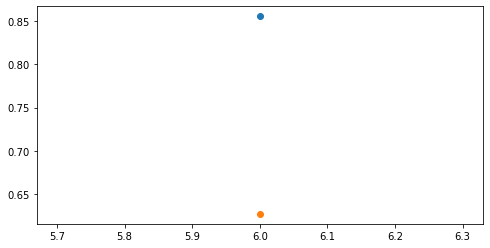

In [99]:
for i in range(len(tot_acc_list)):
    print(thres_list[i])
    print(tot_acc_list[i])
    print(tot_list_area[i])
    plt.figure(figsize = (8, 4))
    plt.plot(range_val,tot_acc_list[i])
    plt.plot(range_val,tot_list_area[i])
    plt.scatter(range_val, tot_acc_list[i])
    plt.scatter(range_val, tot_list_area[i])
    plt.show()

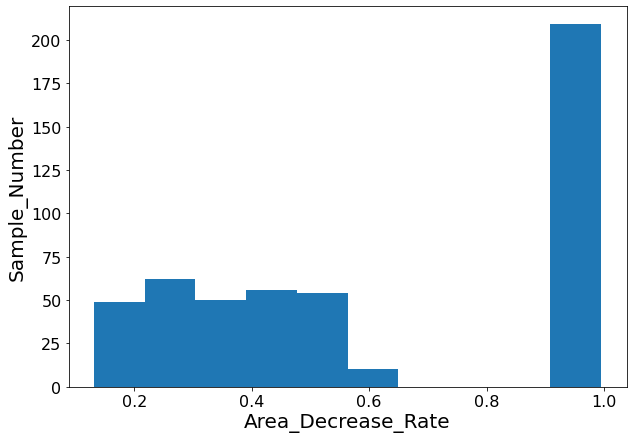

In [100]:
plt.figure(figsize = (10, 7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('axes', labelsize=20)
plt.xlabel('Area_Decrease_Rate')
plt.ylabel('Sample_Number')
plt.hist(model.area_list)
plt.show()

In [86]:
def make_range2(x_list, y_list):
    min_x = min(x_list)
    max_x = max(x_list)
    
    min_y = min(y_list)
    max_y = max(y_list)
    
    tot_ans_x = []
    tot_ans_y = []
        
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            if model. mag_df.iloc[int(x), int(y)] != 0.0:
                tot_ans_x.append(x)
                tot_ans_y.append(y)
    
    return tot_ans_x, tot_ans_y

In [87]:
all_x = list(float(i.split('\t')[0]) for i in list(model.fil_test_df['x_y'].unique()))
all_y = list(float(i.split('\t')[1]) for i in list(model.fil_test_df['x_y'].unique()))

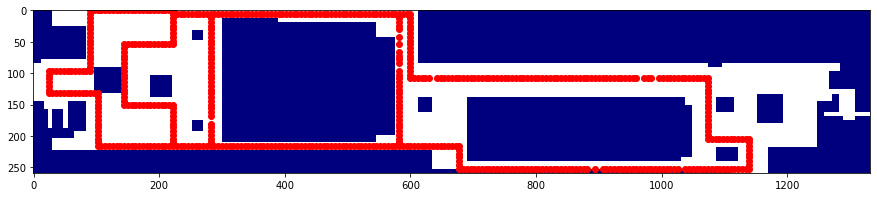

In [88]:
plt.figure(figsize = (15, 11))
plt.imshow(model.mag_df, cmap='jet', interpolation='none')
plt.scatter(all_y, all_x, c = 'r')

0 222 222 606
0.0 216.0


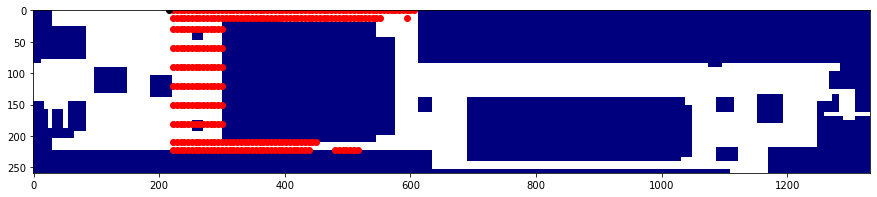

0 222 222 606
0.0 210.0


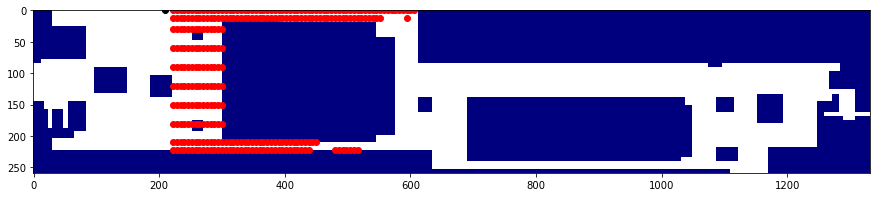

0 222 222 516
0.0 204.0


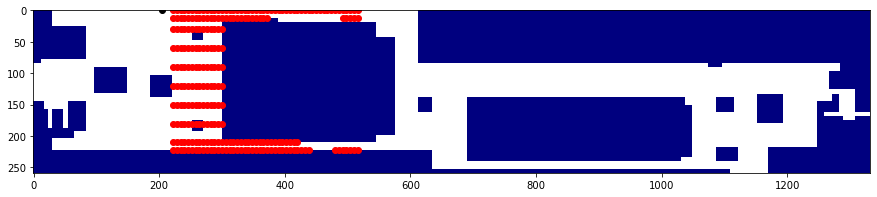

0 222 222 516
0.0 198.0


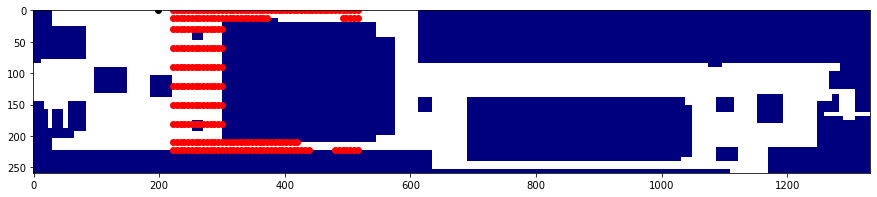

0 222 222 516
0.0 192.0


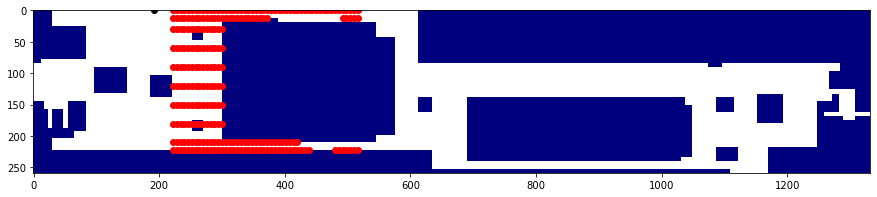

0 222 222 516
0.0 186.0


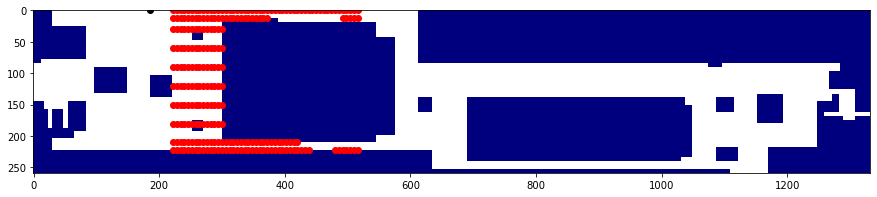

0 222 222 516
0.0 180.0


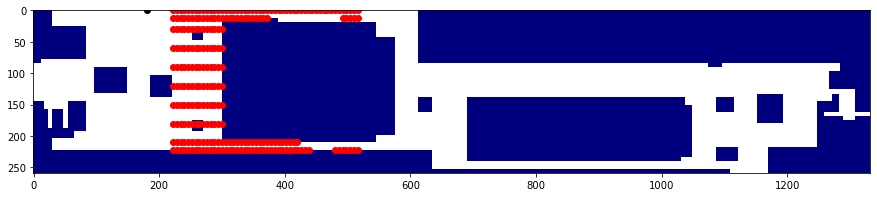

0 222 222 606
0.0 174.0


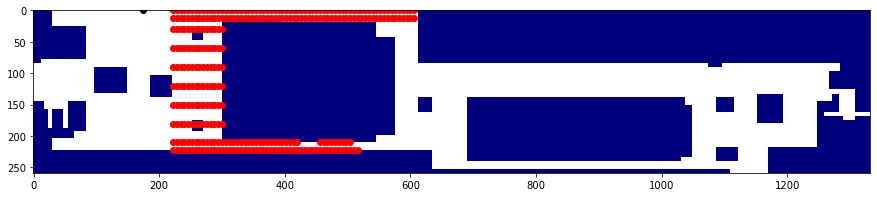

0 222 222 606
0.0 168.0


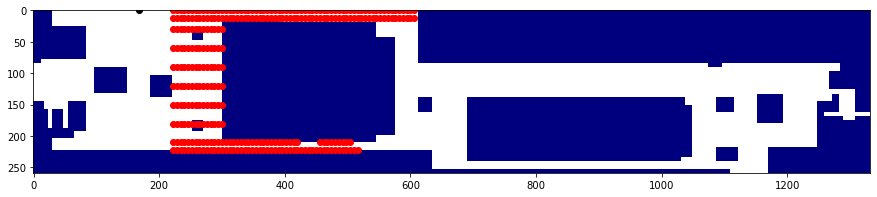

0 222 222 606
0.0 162.0


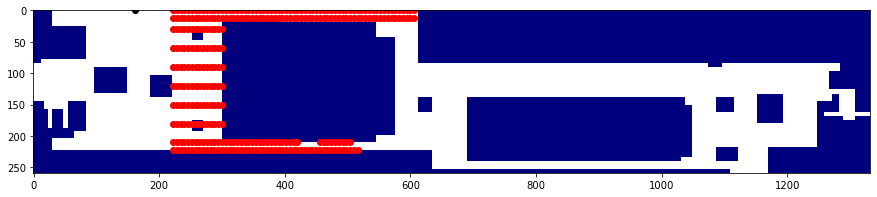

0 222 222 606
0.0 156.0


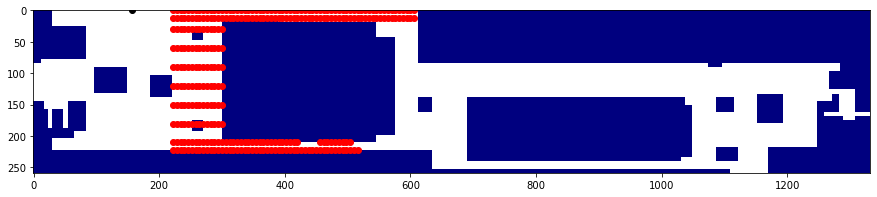

0 222 222 606
0.0 150.0


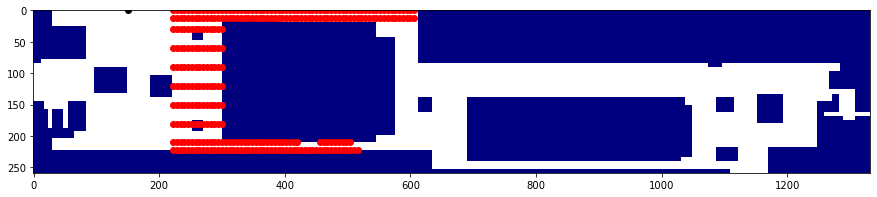

0 222 222 426
0.0 144.0


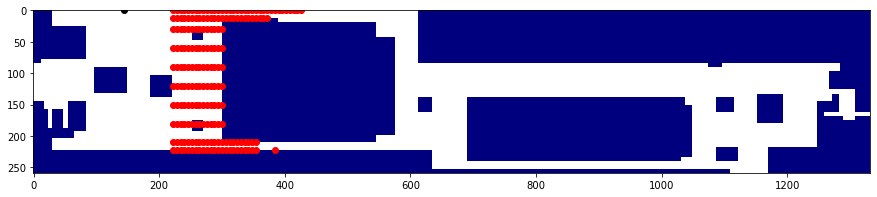

0 222 222 426
0.0 138.0


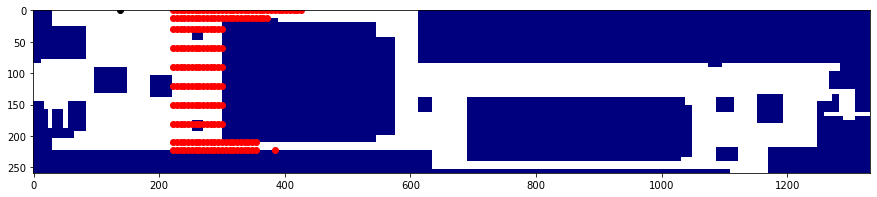

0 222 222 426
0.0 132.0


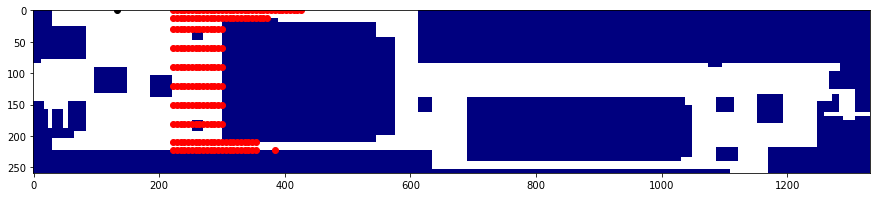

0 222 222 426
0.0 126.0


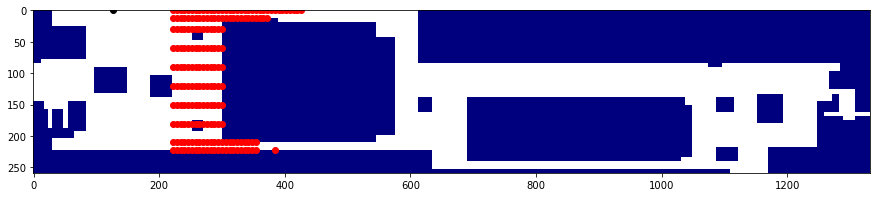

0 222 222 426
0.0 120.0


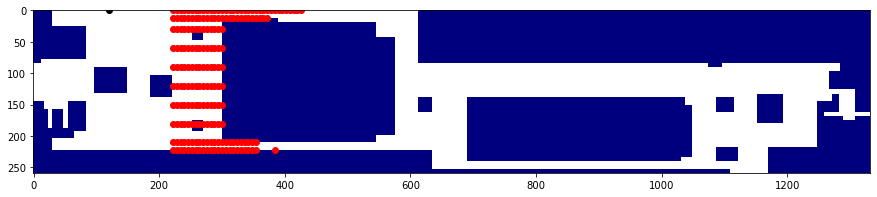

0 222 222 426
0.0 114.0


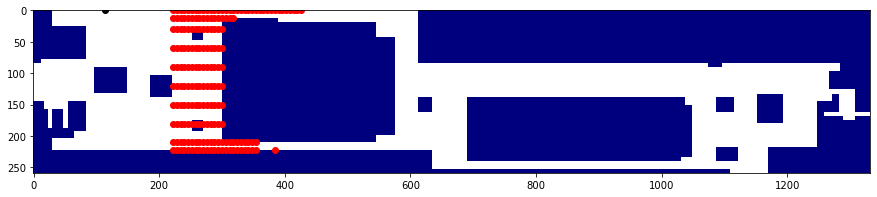

0 222 222 426
0.0 108.0


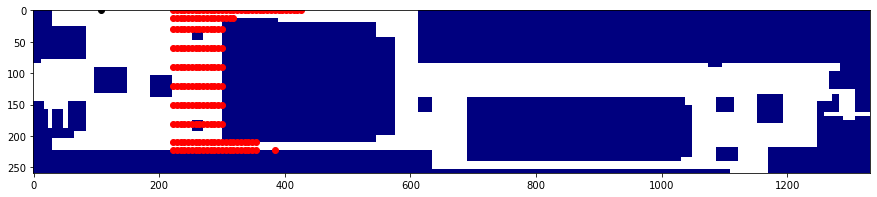

0 222 222 426
0.0 102.0


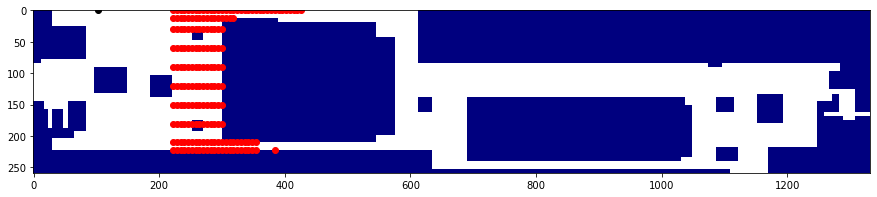

0 222 222 426
0.0 96.0


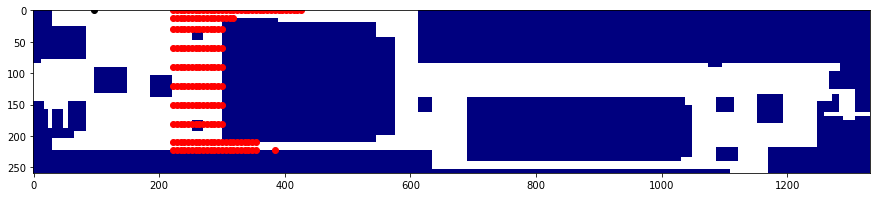

0 222 222 426
0.0 90.0


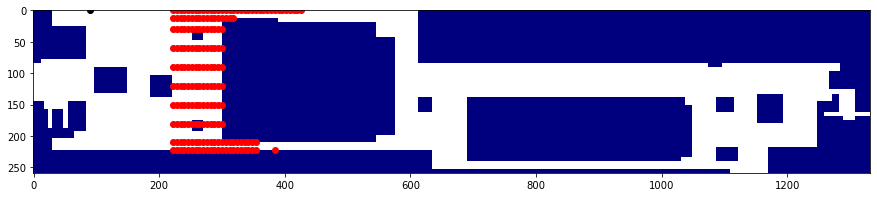

0 222 222 606
6.0 90.0


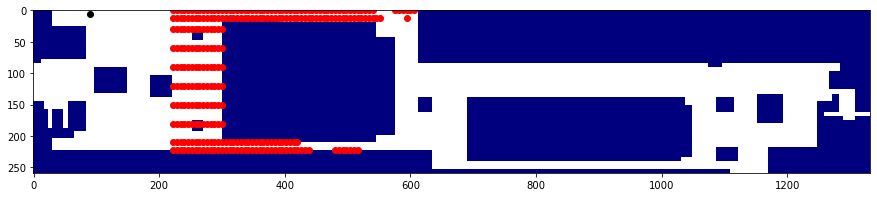

0 222 222 606
12.0 90.0


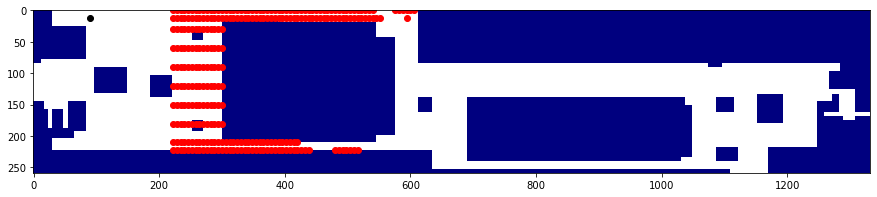

0 222 222 606
18.0 90.0


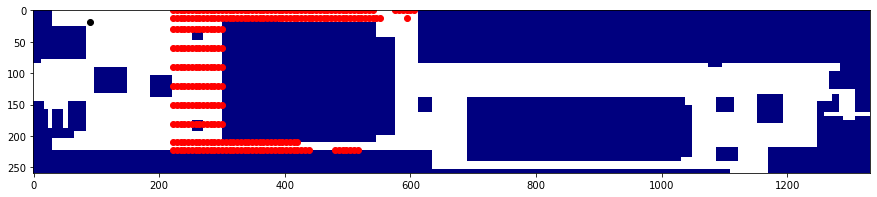

0 222 222 606
24.0 90.0


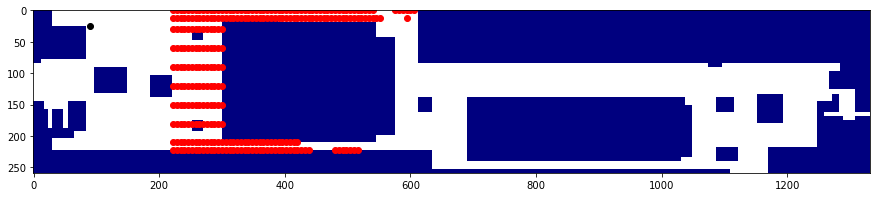

0 222 222 606
30.0 90.0


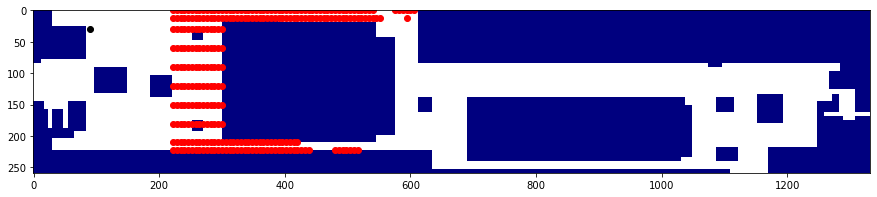

0 222 222 606
36.0 90.0


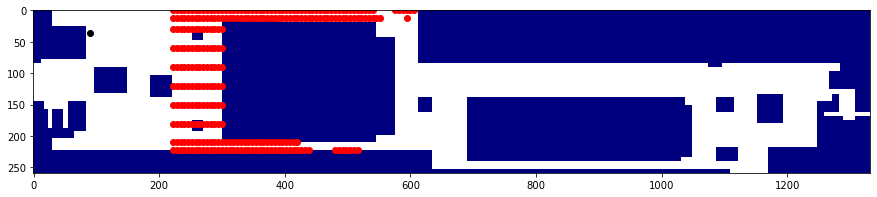

0 222 222 606
42.0 90.0


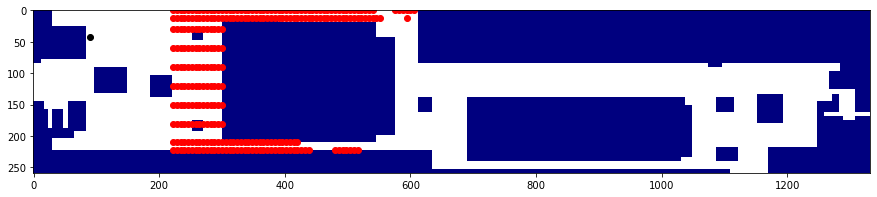

0 222 222 606
48.0 90.0


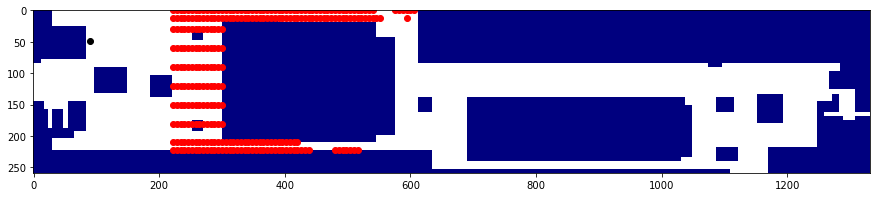

0 222 222 606
54.0 216.0


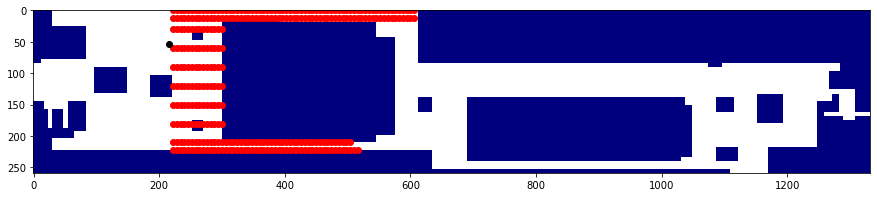

0 222 222 606
54.0 210.0


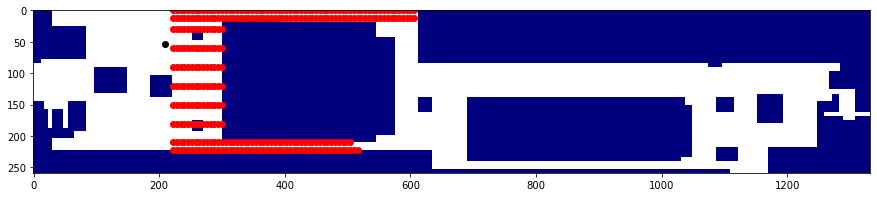

0 222 222 606
54.0 204.0


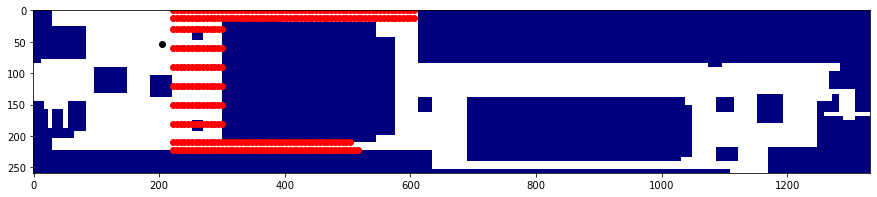

0 222 222 606
54.0 198.0


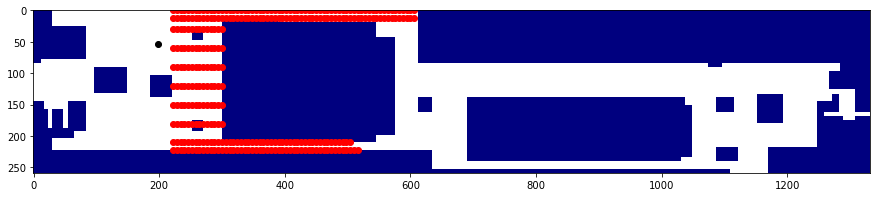

0 222 222 426
54.0 192.0


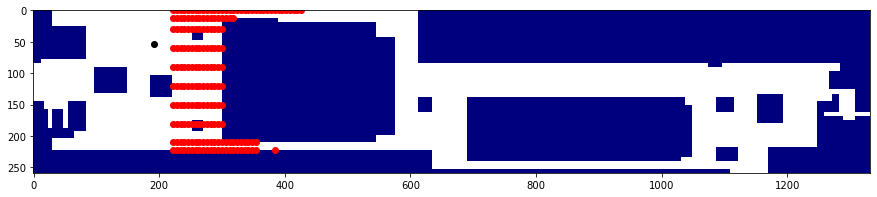

0 222 222 426
54.0 186.0


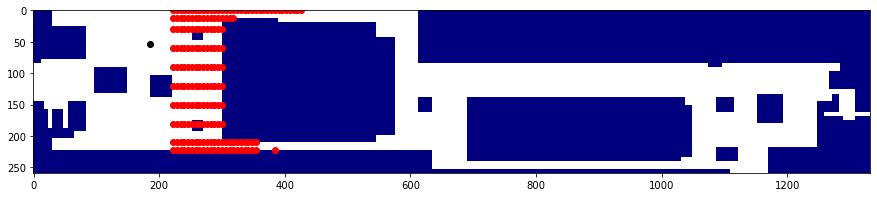

0 222 222 426
54.0 180.0


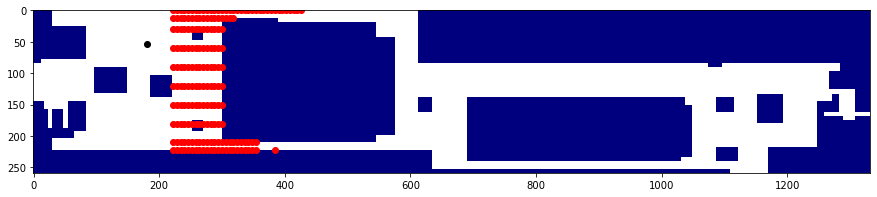

0 222 222 426
54.0 174.0


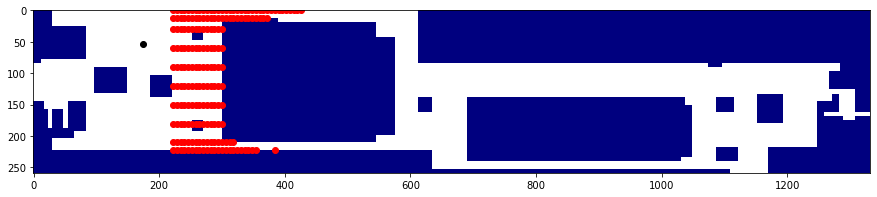

0 222 222 426
54.0 168.0


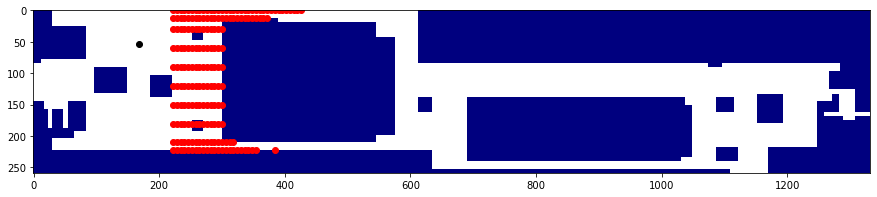

0 222 222 426
54.0 162.0


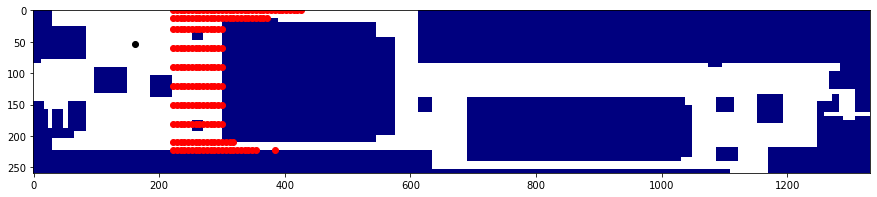

0 222 222 426
54.0 156.0


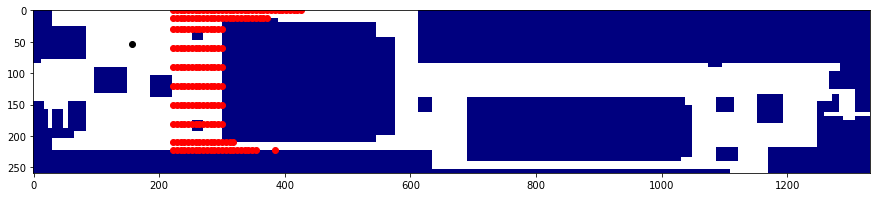

0 222 222 516
54.0 150.0


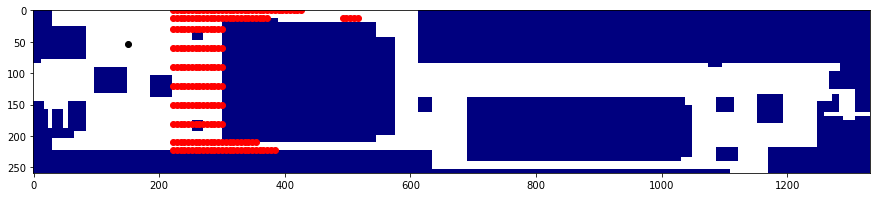

0 222 222 516
54.0 144.0


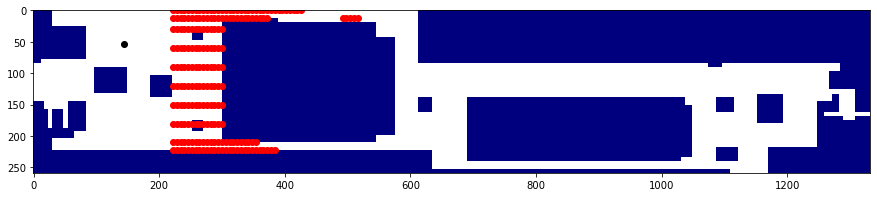

0 222 222 606
54.0 90.0


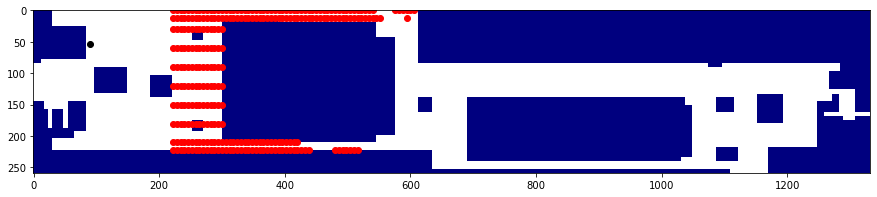

0 222 222 426
60.0 144.0


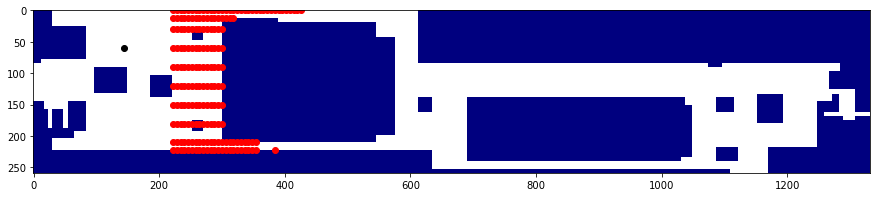

0 222 222 606
60.0 90.0


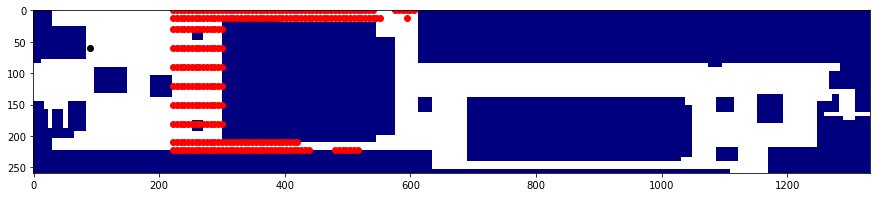

0 222 222 426
66.0 144.0


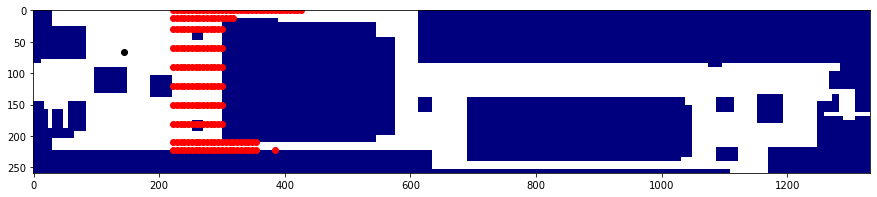

0 222 222 438
66.0 90.0


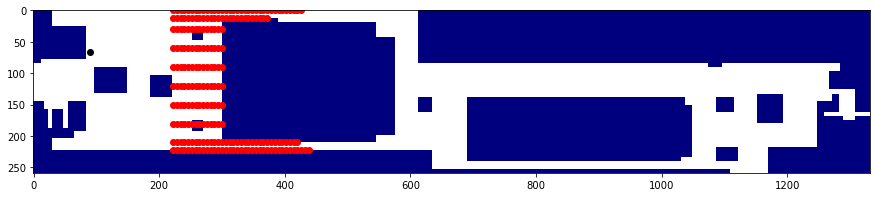

0 222 222 426
72.0 144.0


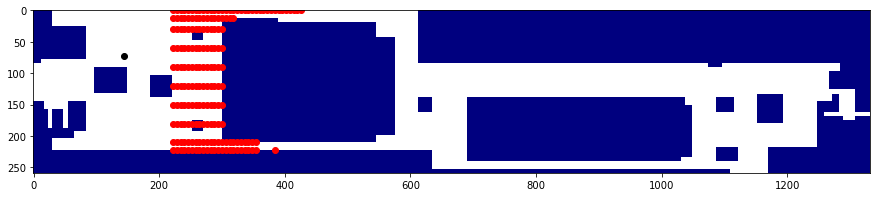

0 222 222 438
72.0 90.0


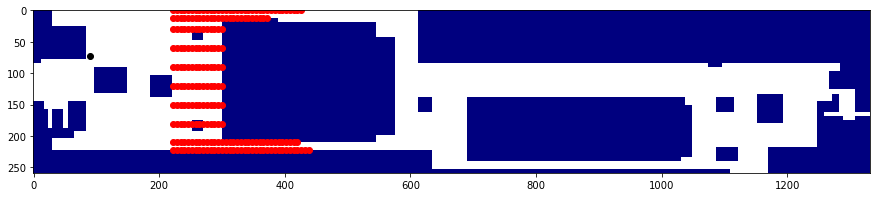

0 222 222 426
78.0 144.0


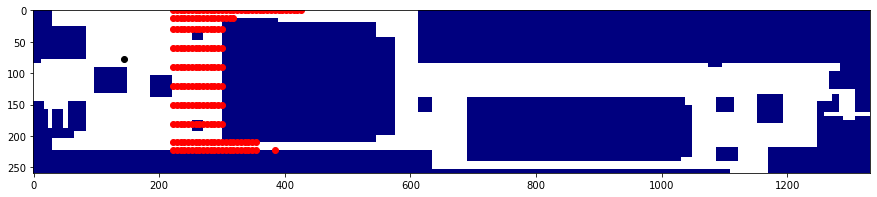

0 222 222 438
78.0 90.0


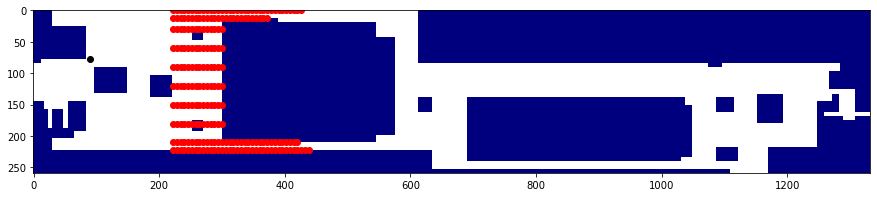

0 222 222 426
84.0 144.0


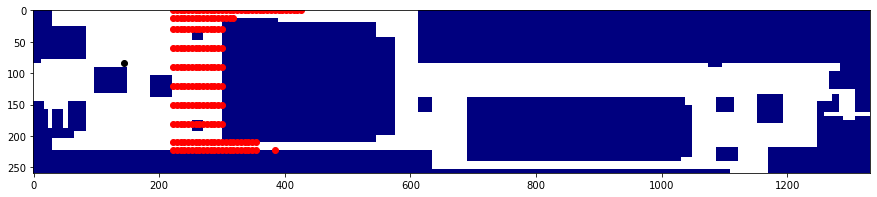

0 222 222 438
84.0 90.0


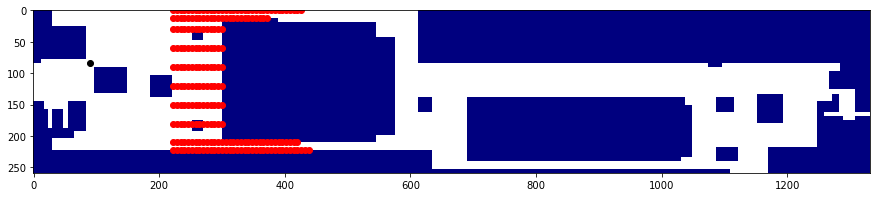

0 222 222 426
90.0 144.0


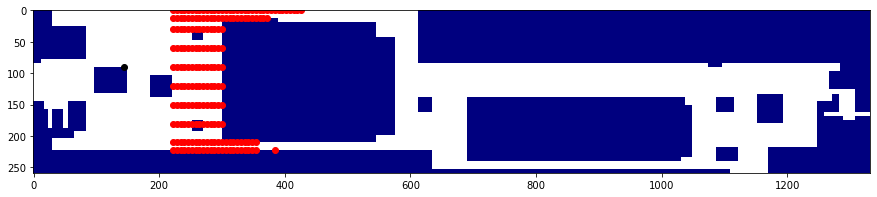

0 222 222 438
90.0 90.0


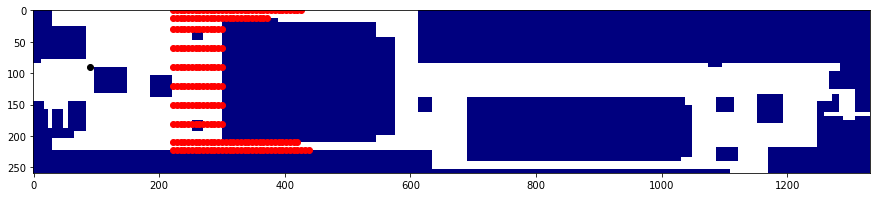

0 222 222 426
96.0 144.0


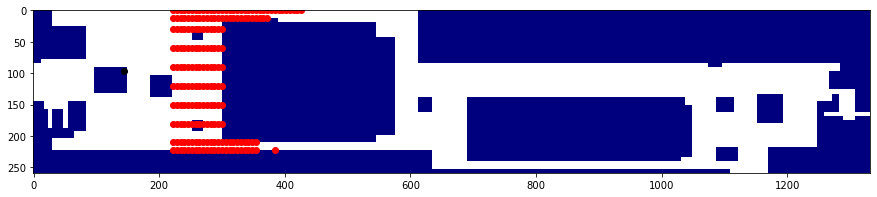

0 222 222 516
96.0 72.0


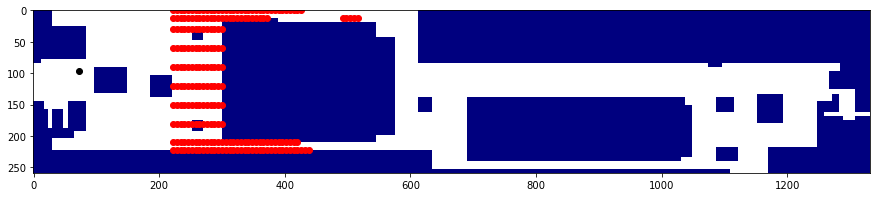

0 222 222 516
96.0 66.0


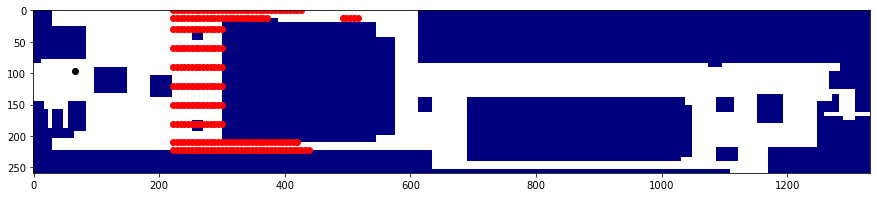

0 222 222 516
96.0 60.0


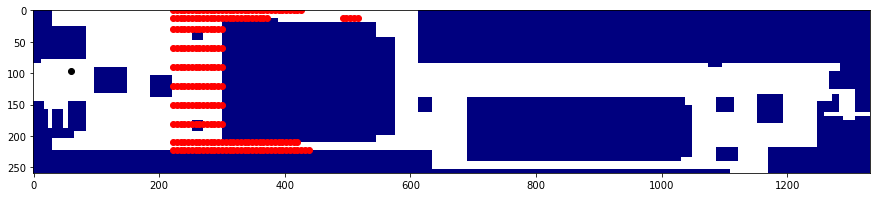

0 222 222 516
96.0 54.0


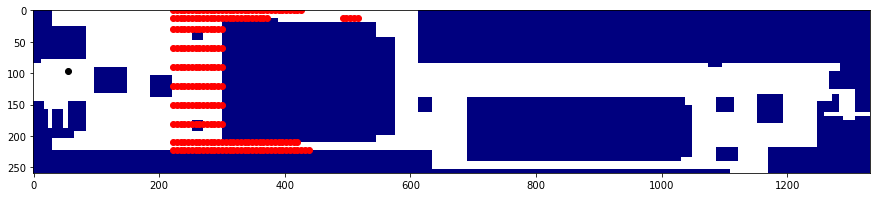

0 222 222 516
96.0 48.0


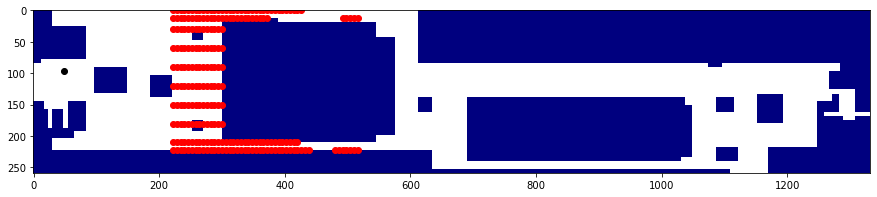

0 222 222 516
96.0 42.0


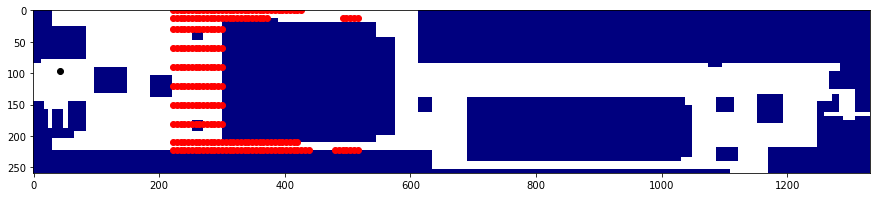

0 222 222 516
96.0 36.0


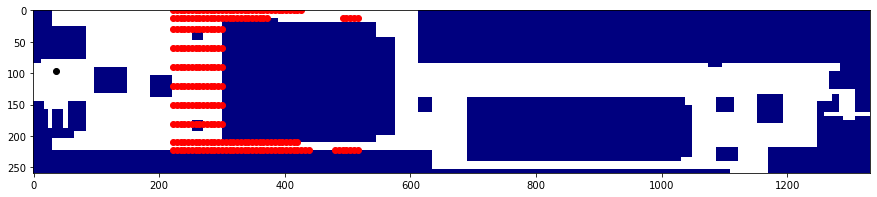

0 222 222 516
96.0 30.0


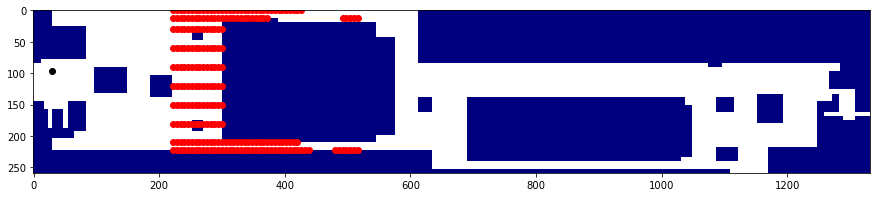

0 222 222 516
96.0 24.0


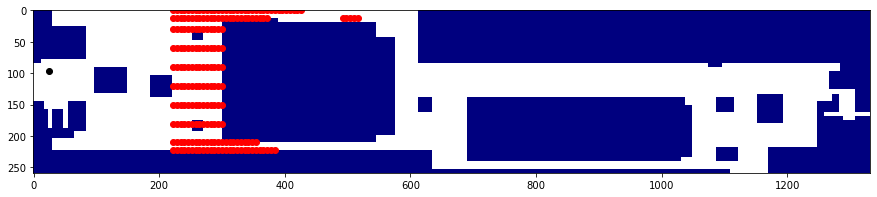

0 222 222 426
102.0 144.0


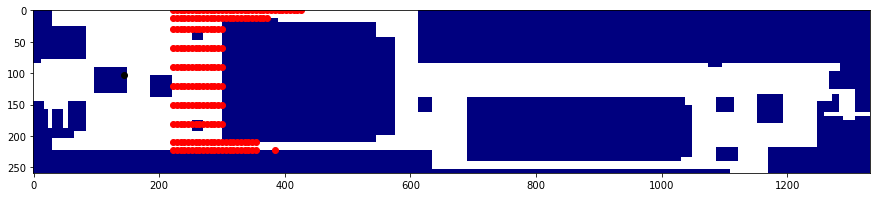

0 222 222 516
102.0 24.0


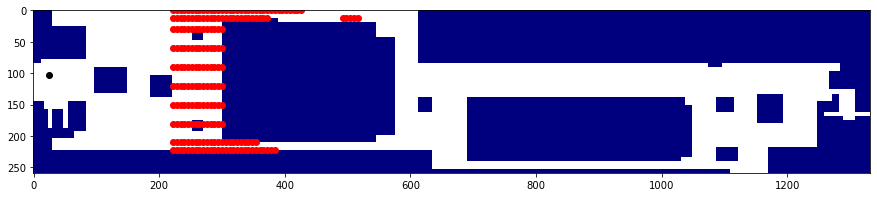

0 222 222 426
108.0 144.0


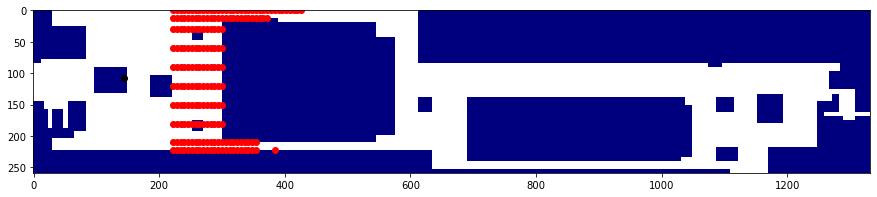

0 222 222 516
108.0 24.0


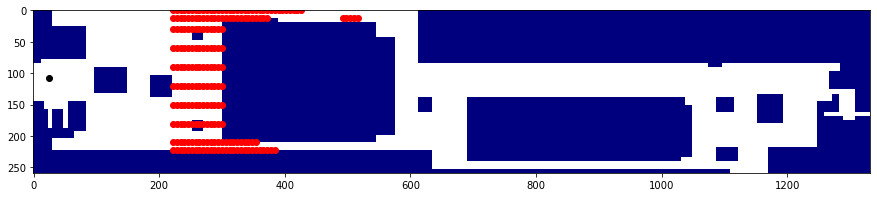

0 222 222 426
114.0 144.0


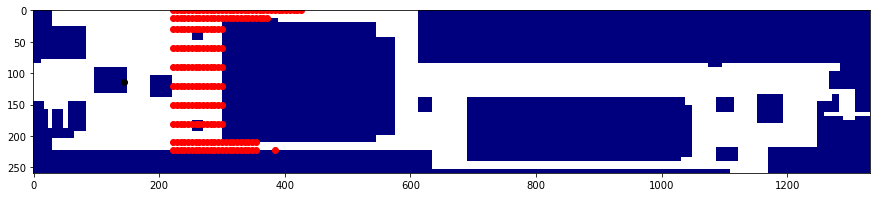

0 222 222 516
114.0 24.0


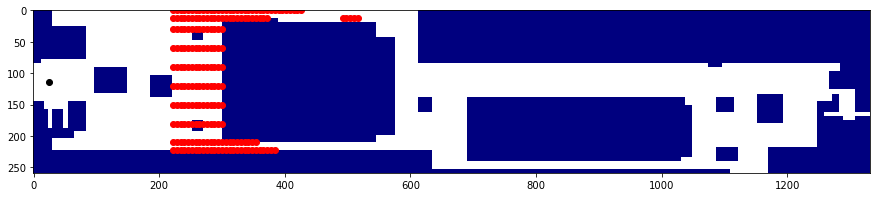

0 222 222 426
120.0 144.0


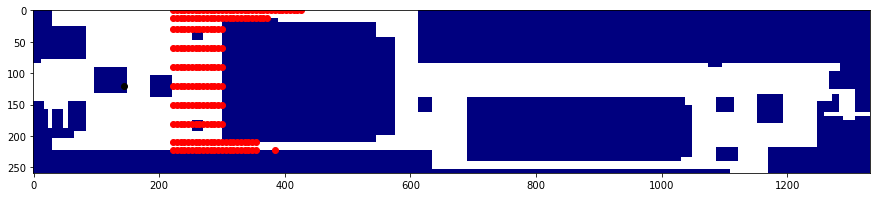

0 222 222 438
120.0 24.0


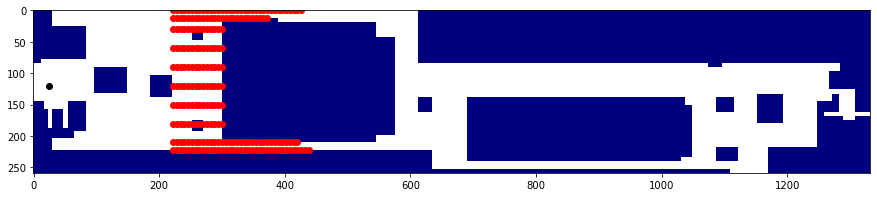

0 222 222 606
126.0 144.0


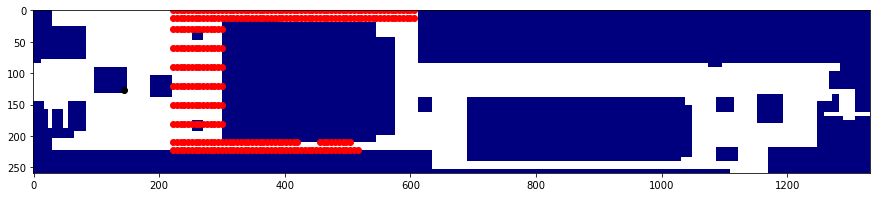

0 222 222 516
126.0 24.0


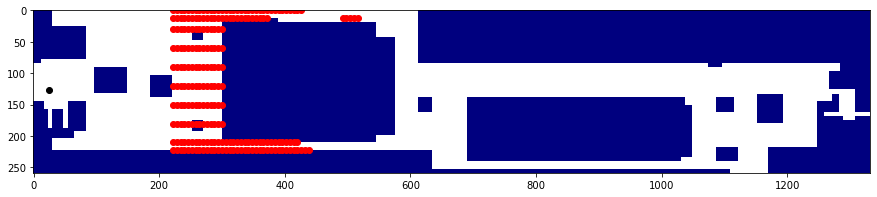

0 222 222 606
132.0 144.0


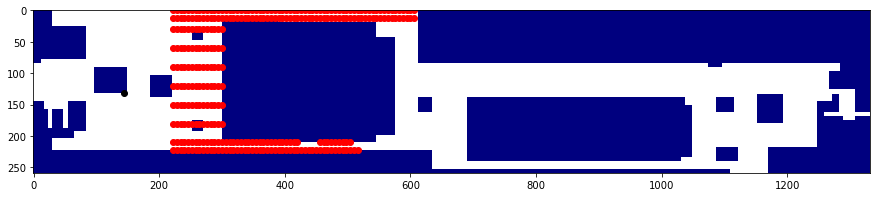

0 222 222 426
132.0 102.0


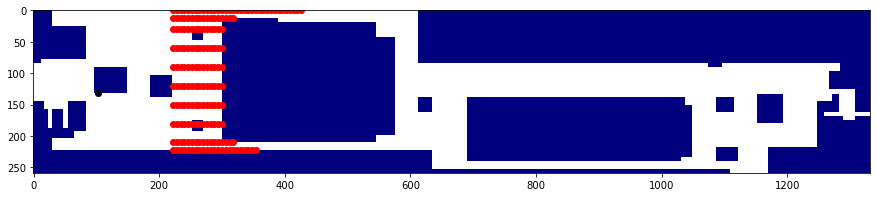

0 222 222 516
132.0 96.0


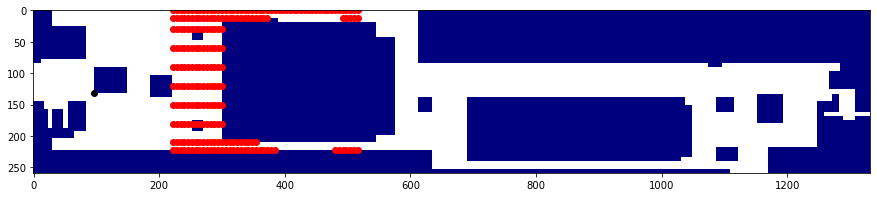

0 222 222 516
132.0 90.0


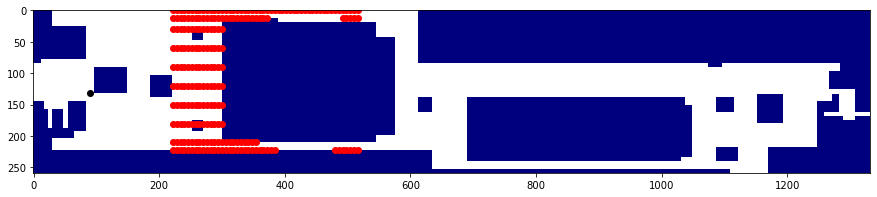

0 222 222 606
132.0 84.0


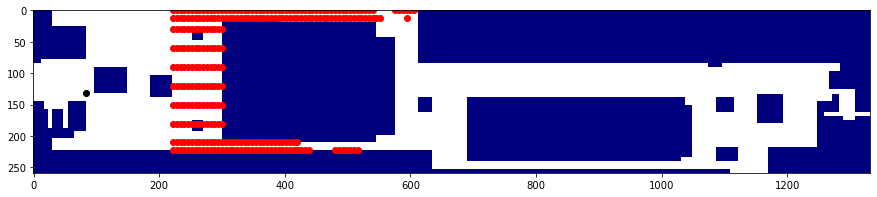

0 222 222 606
132.0 78.0


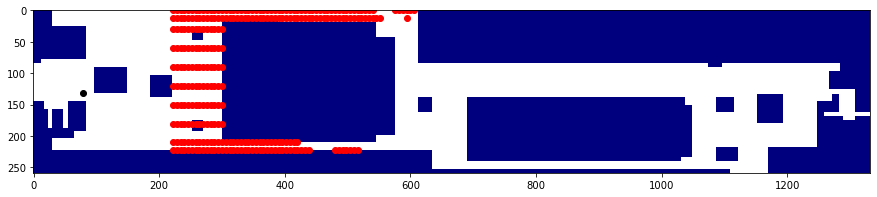

0 222 222 606
132.0 72.0


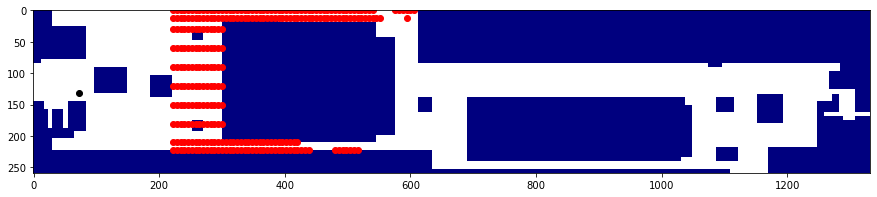

0 222 222 606
132.0 66.0


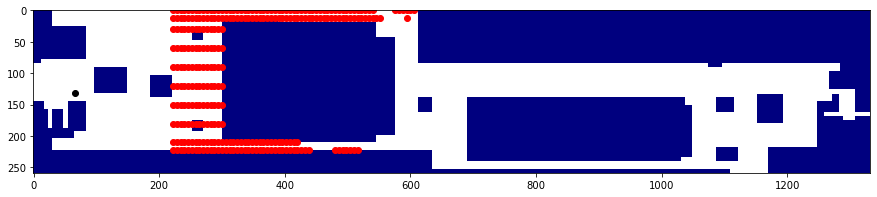

0 222 222 606
132.0 60.0


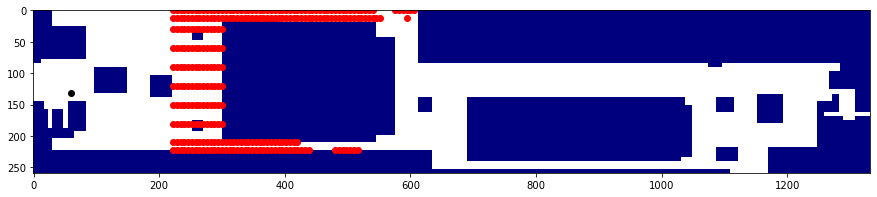

0 222 222 606
132.0 54.0


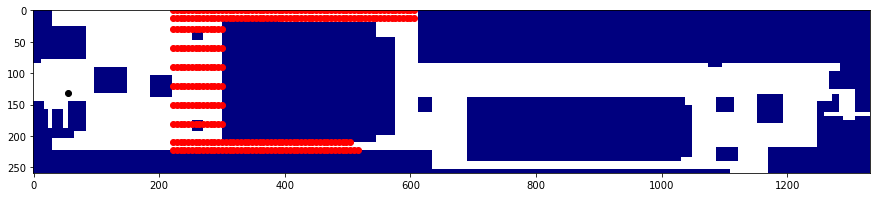

0 222 222 606
132.0 48.0


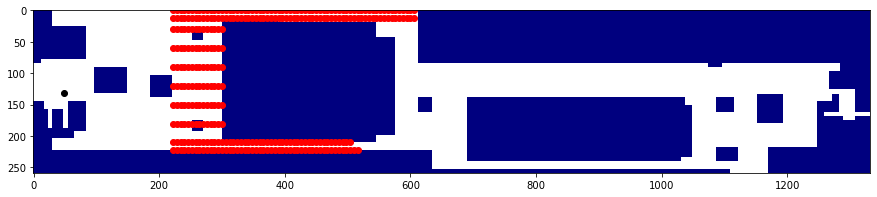

0 222 222 606
132.0 42.0


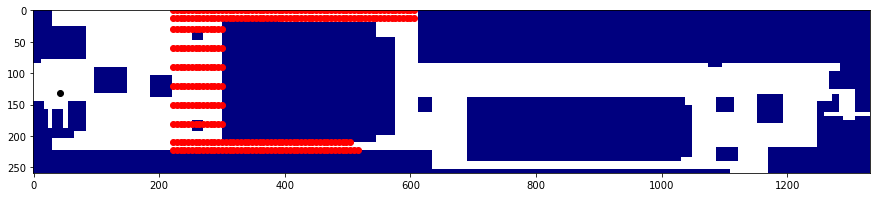

0 222 222 606
132.0 36.0


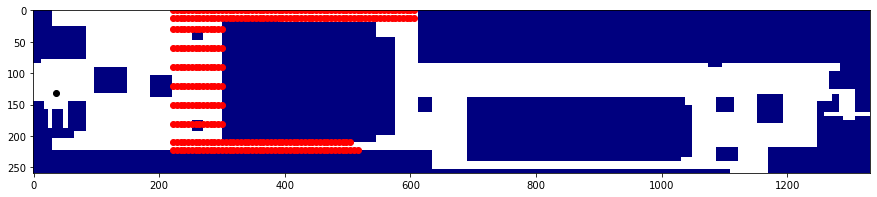

0 222 222 606
132.0 30.0


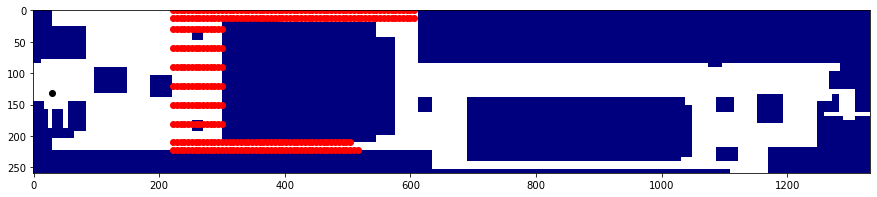

0 222 222 516
132.0 24.0


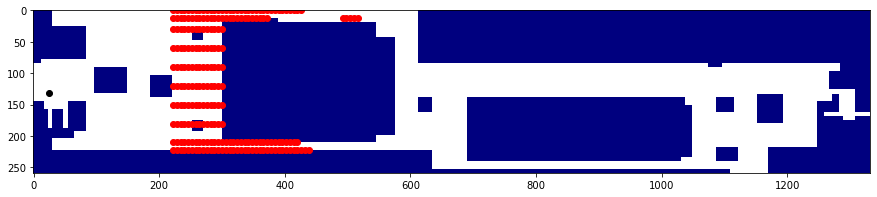

0 222 222 606
138.0 144.0


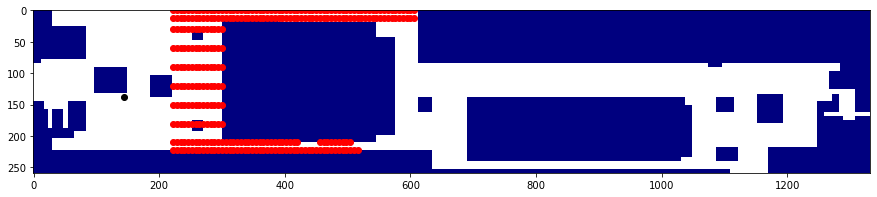

0 222 222 606
138.0 102.0


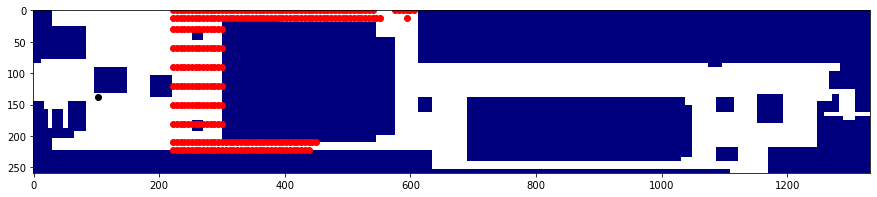

0 222 222 606
144.0 144.0


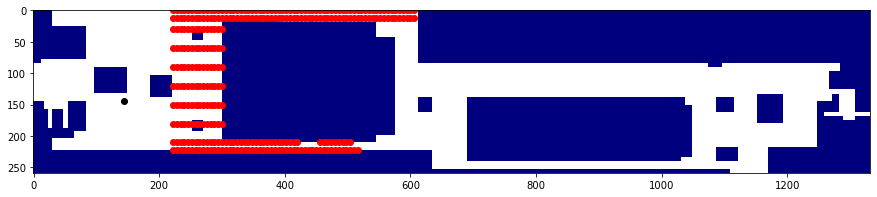

0 222 222 606
144.0 102.0


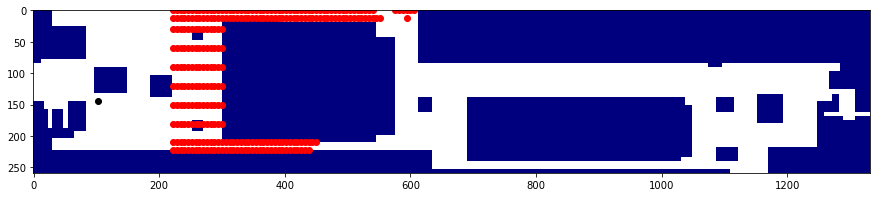

0 222 222 426
150.0 216.0


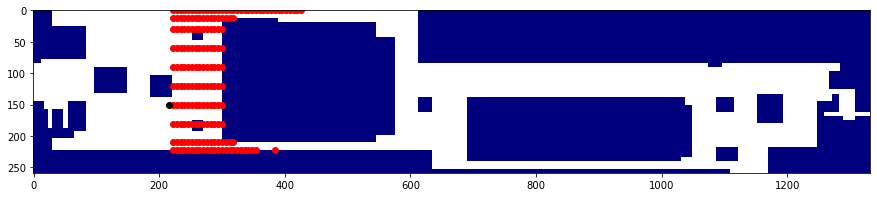

0 222 222 606
150.0 210.0


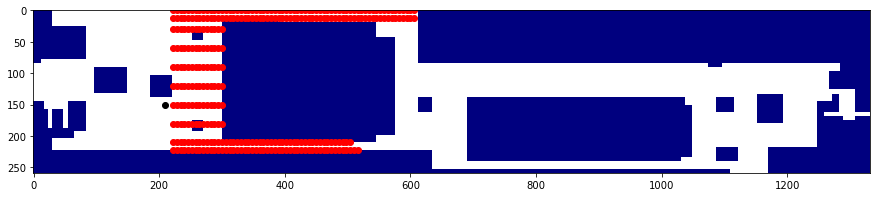

0 222 222 606
150.0 204.0


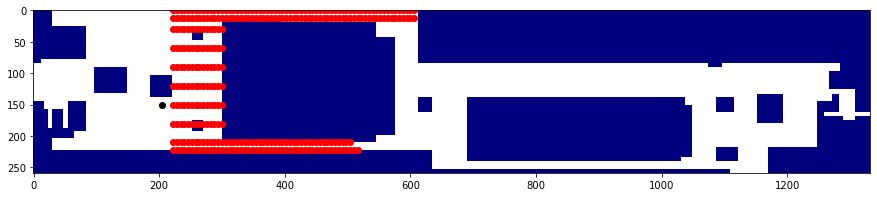

0 222 222 606
150.0 198.0


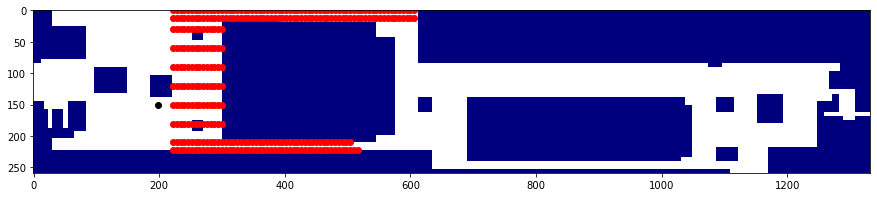

0 222 222 606
150.0 192.0


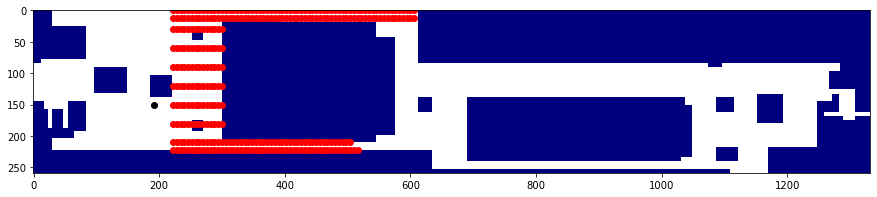

0 222 222 540
150.0 186.0


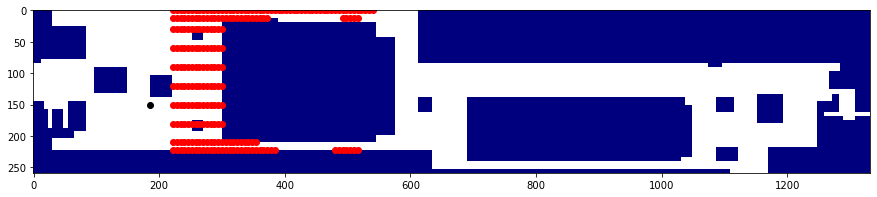

0 222 222 540
150.0 180.0


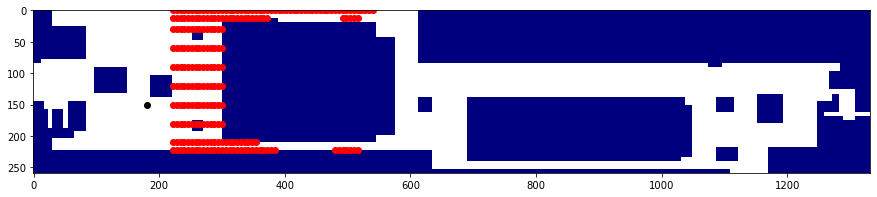

0 222 222 540
150.0 174.0


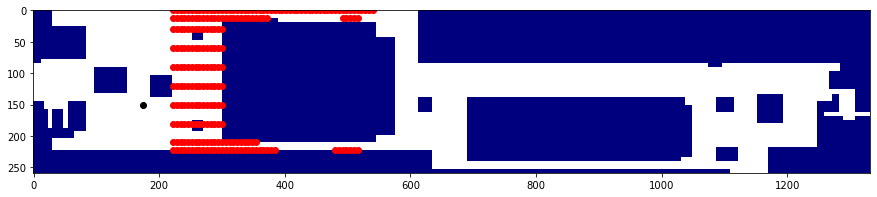

0 222 222 540
150.0 168.0


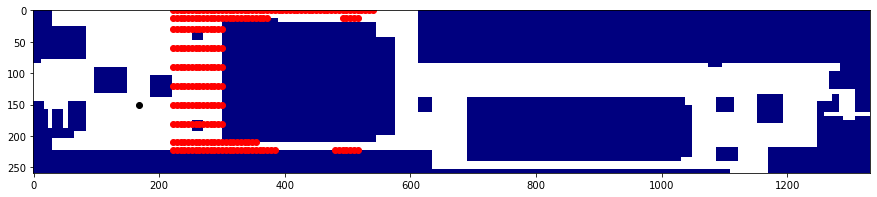

0 222 222 426
150.0 162.0


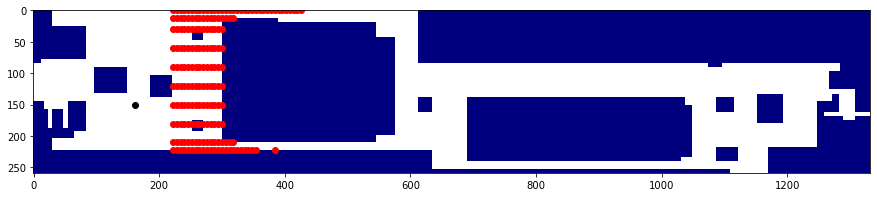

0 222 222 516
150.0 156.0


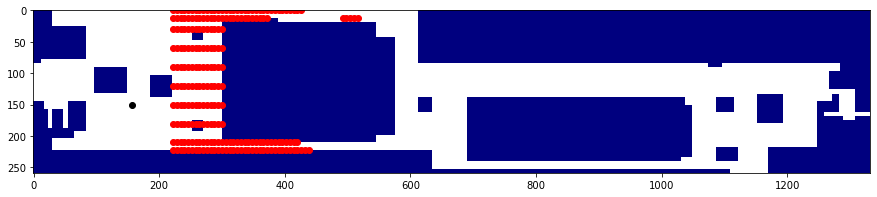

0 222 222 516
150.0 150.0


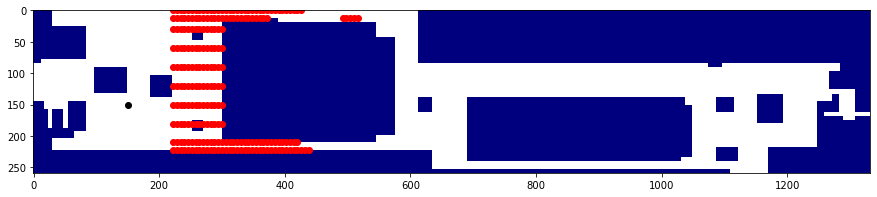

0 222 222 516
150.0 144.0


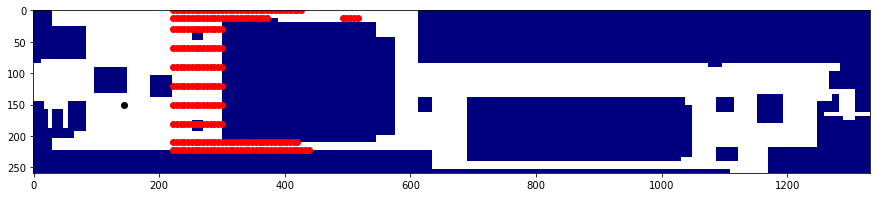

0 222 222 606
150.0 102.0


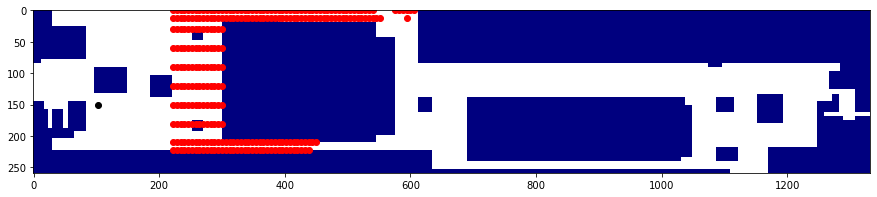

0 222 222 606
156.0 102.0


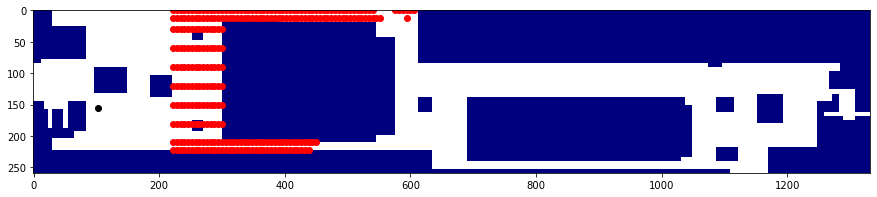

0 222 222 516
162.0 102.0


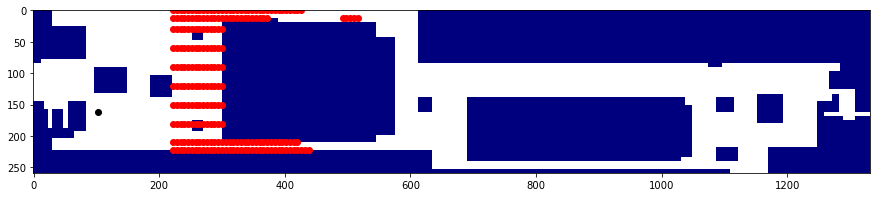

0 222 222 516
168.0 102.0


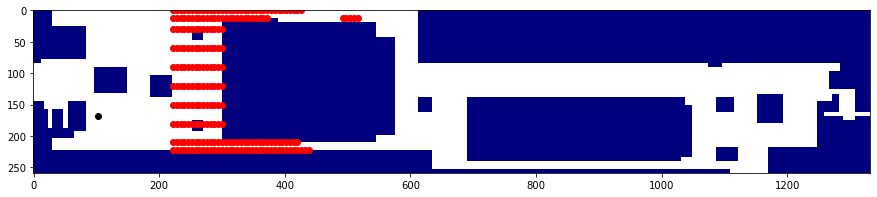

0 222 222 516
174.0 102.0


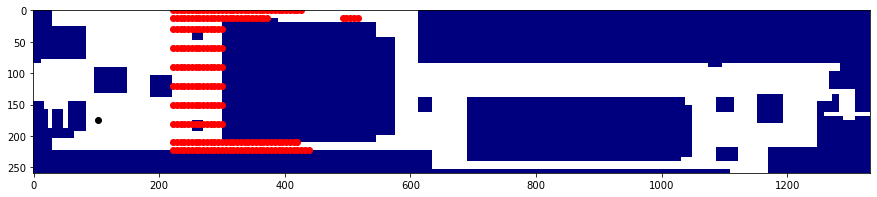

0 222 222 516
180.0 102.0


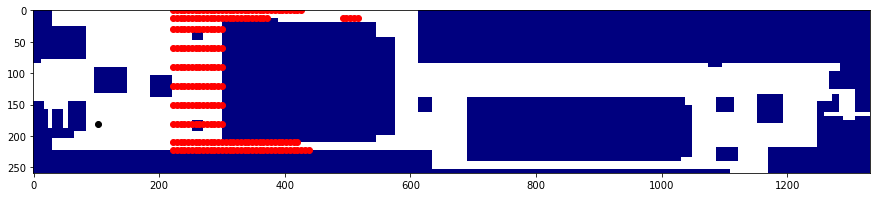

0 222 222 516
186.0 102.0


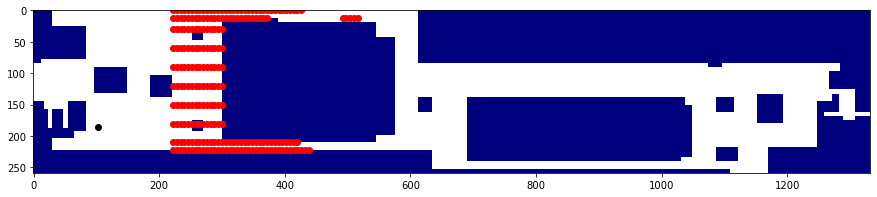

0 222 222 516
192.0 102.0


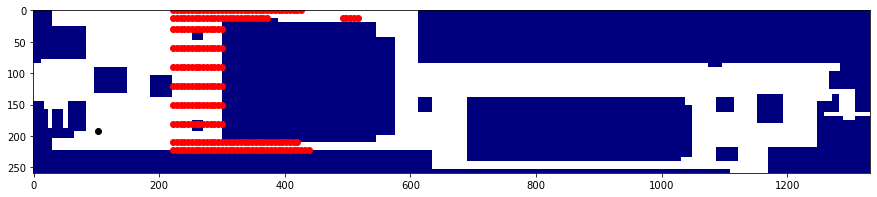

0 222 222 606
198.0 102.0


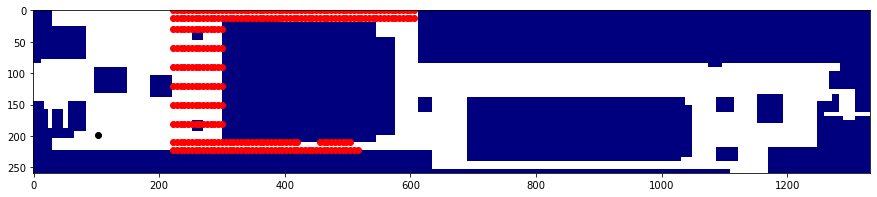

0 222 222 606
204.0 102.0


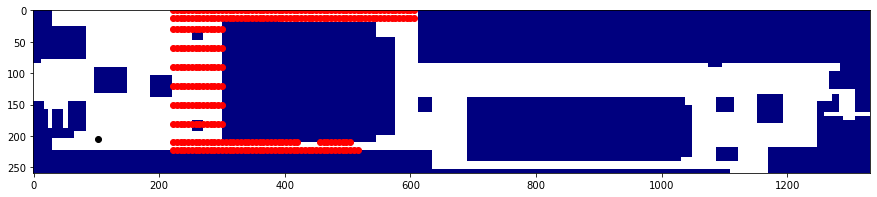

84 258 696 1104
204.0 1110.0


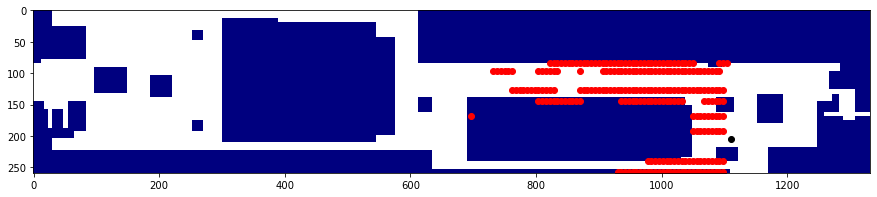

84 258 696 1104
204.0 1116.0


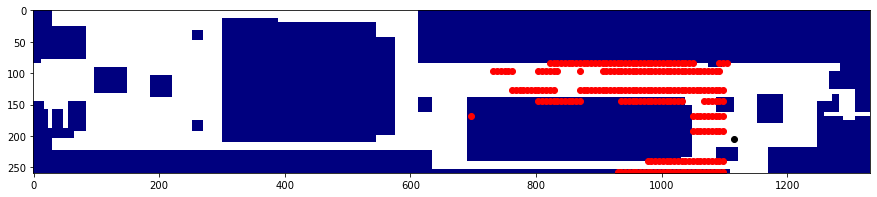

84 258 804 1104
204.0 1122.0


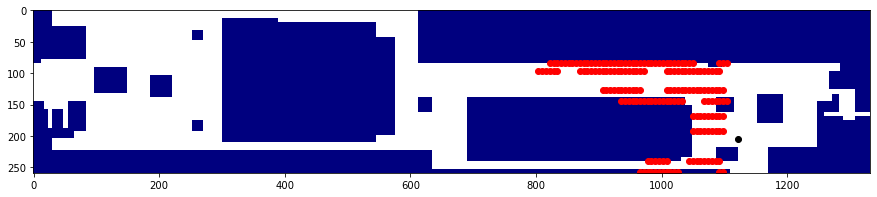

84 258 804 1104
204.0 1128.0


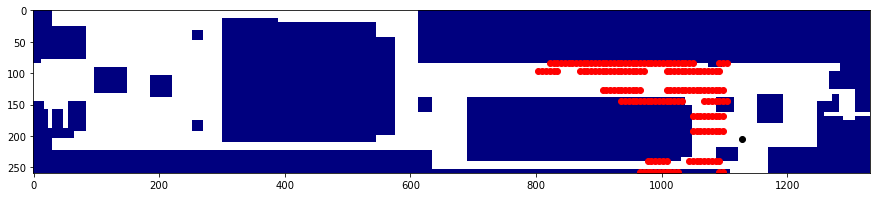

84 258 804 1104
204.0 1134.0


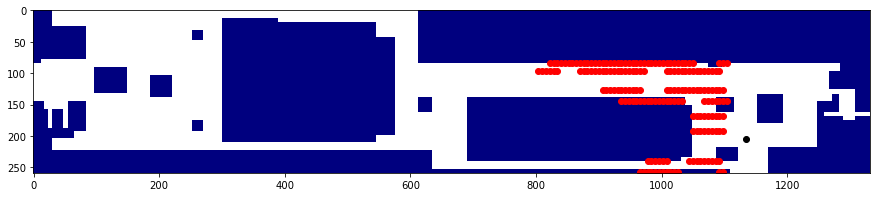

84 258 804 1104
204.0 1140.0


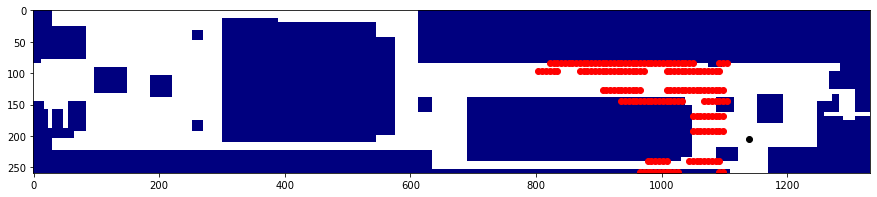

0 222 222 606
210.0 102.0


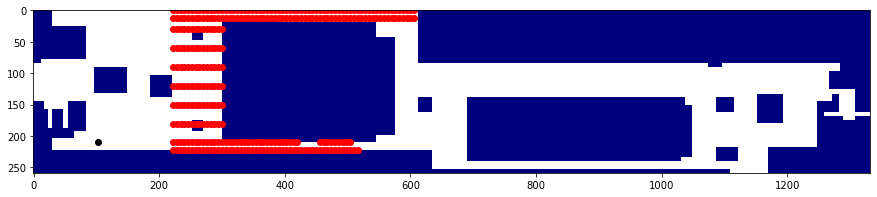

84 258 600 1104
210.0 1140.0


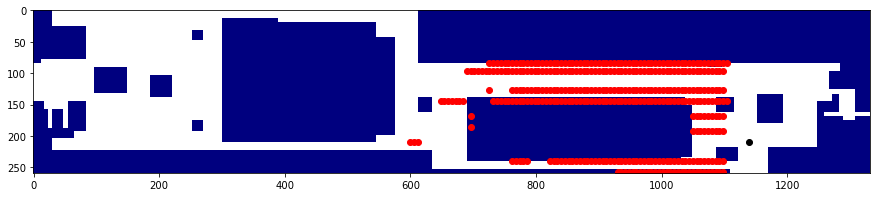

0 222 222 606
216.0 216.0


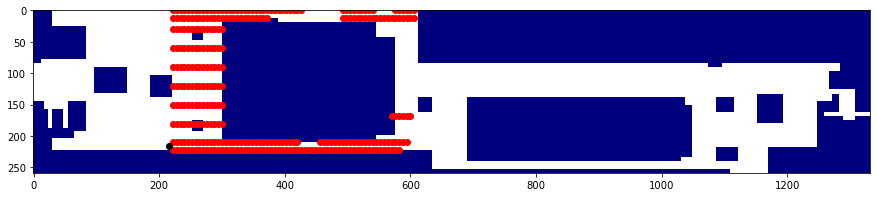

0 222 222 606
216.0 210.0


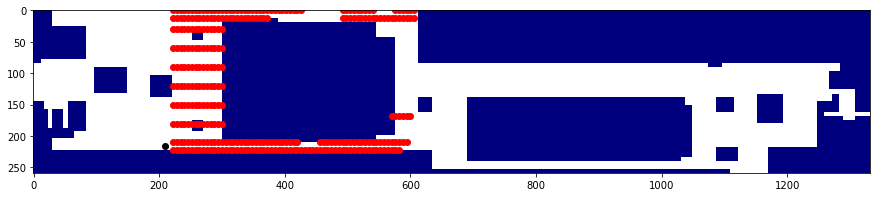

0 222 222 606
216.0 204.0


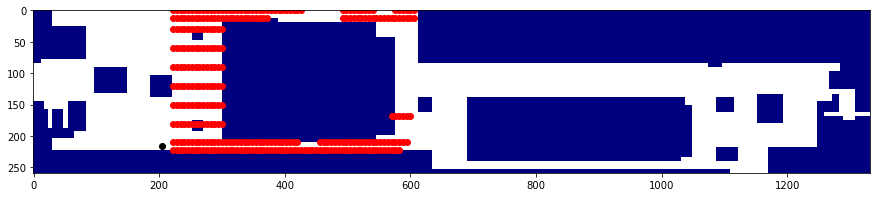

0 222 222 606
216.0 198.0


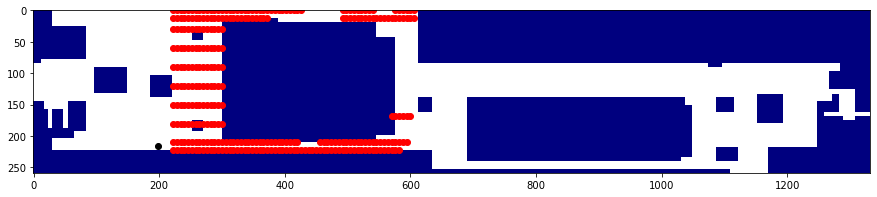

0 222 222 606
216.0 192.0


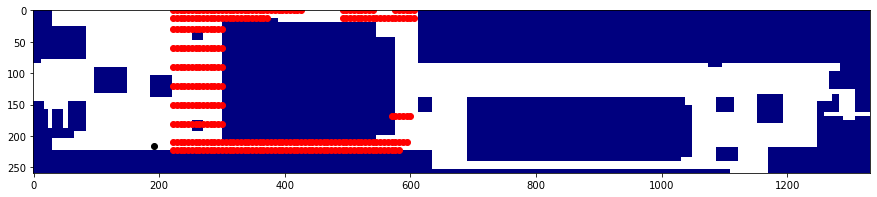

0 222 222 606
216.0 186.0


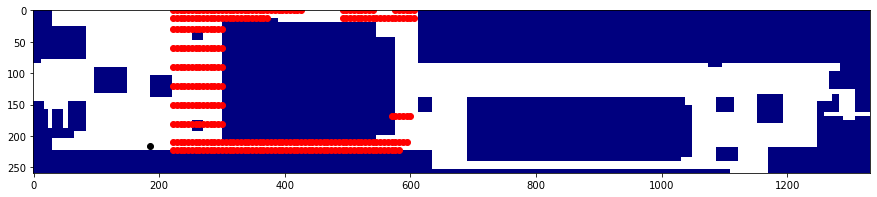

0 222 222 606
216.0 180.0


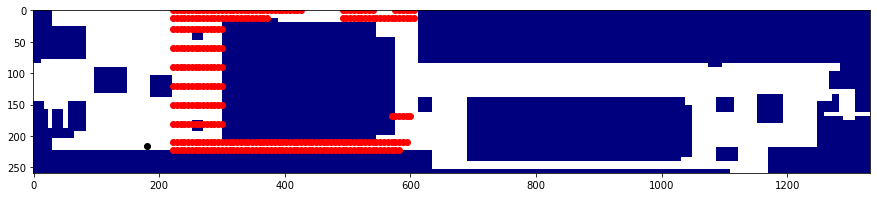

0 222 222 606
216.0 174.0


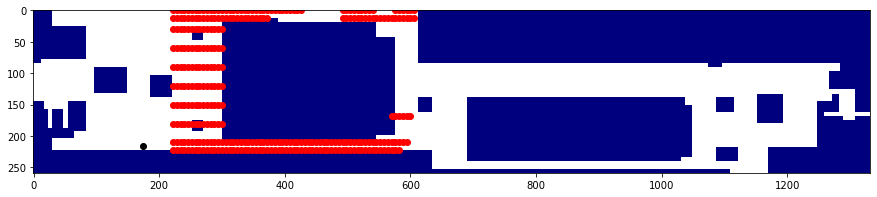

0 222 222 606
216.0 168.0


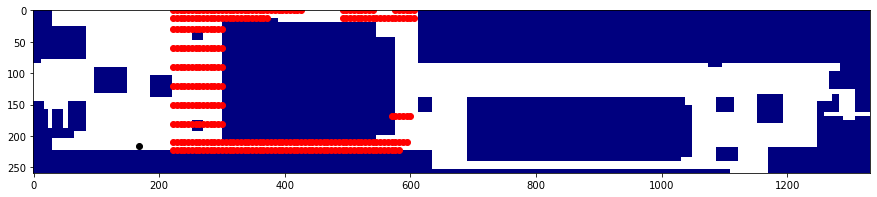

0 222 222 582
216.0 162.0


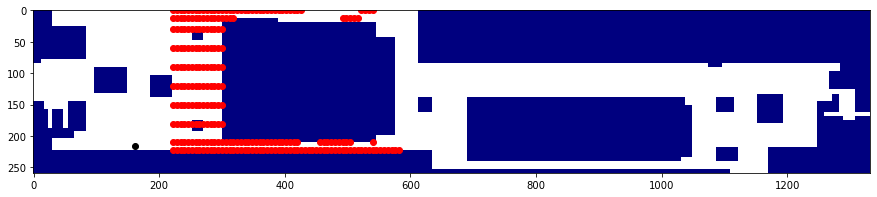

0 258 222 1092
216.0 156.0


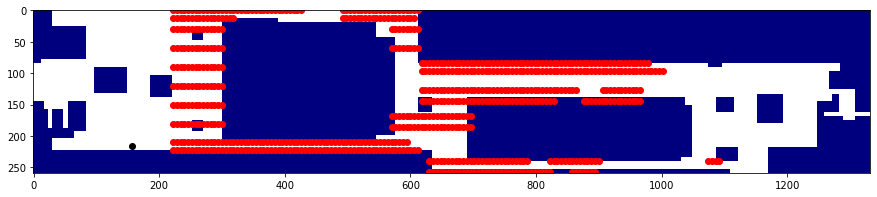

0 258 222 1092
216.0 150.0


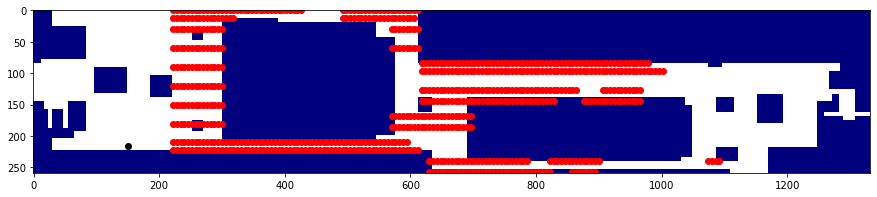

0 258 222 1092
216.0 144.0


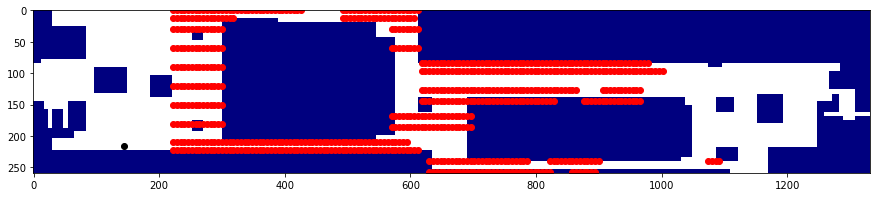

0 258 222 1092
216.0 138.0


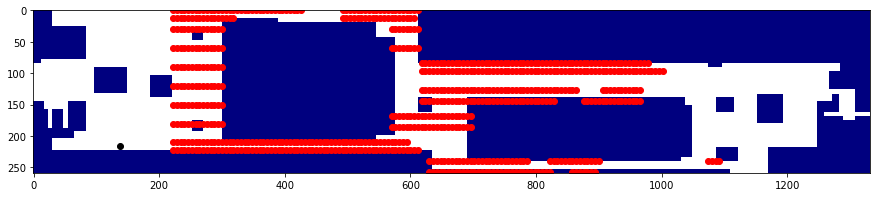

0 258 222 1104
216.0 132.0


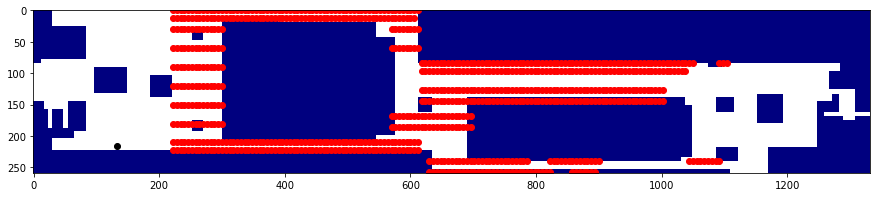

0 258 222 1104
216.0 126.0


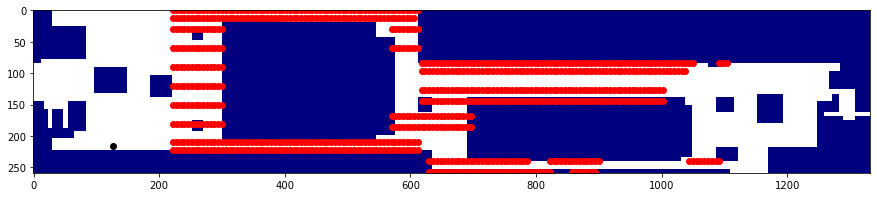

0 258 222 1104
216.0 120.0


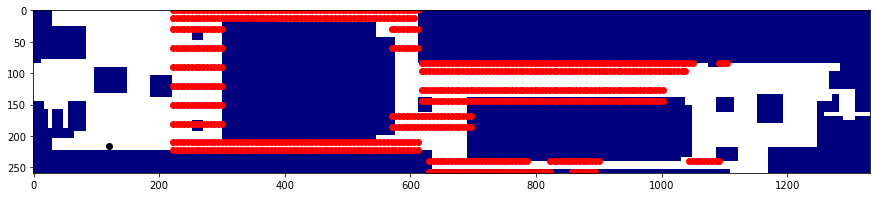

0 258 222 1104
216.0 114.0


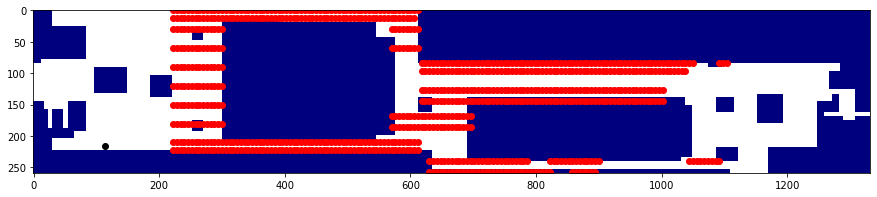

0 258 222 1104
216.0 108.0


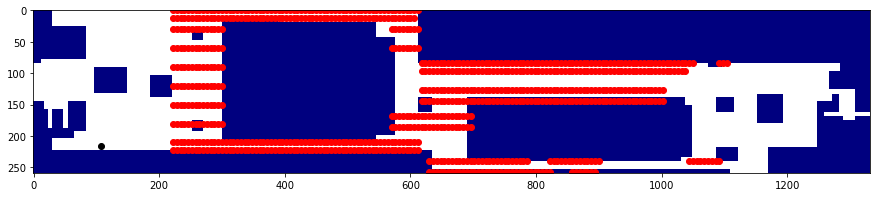

0 222 222 606
216.0 102.0


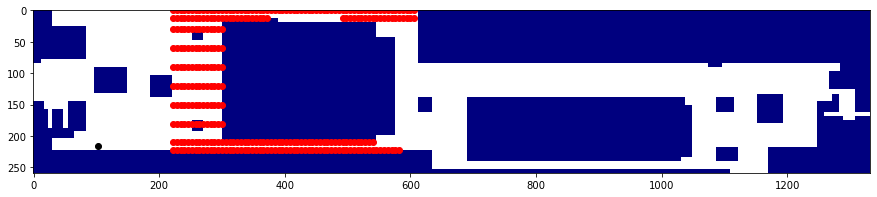

84 258 600 1104
216.0 1140.0


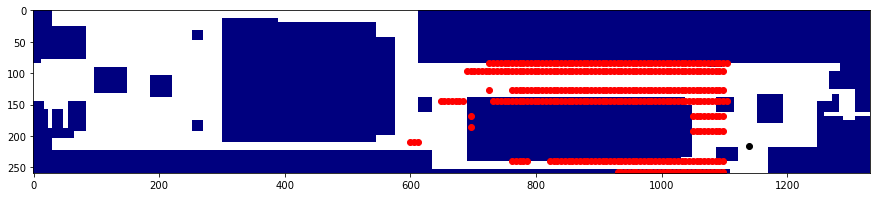

84 258 600 1104
222.0 1140.0


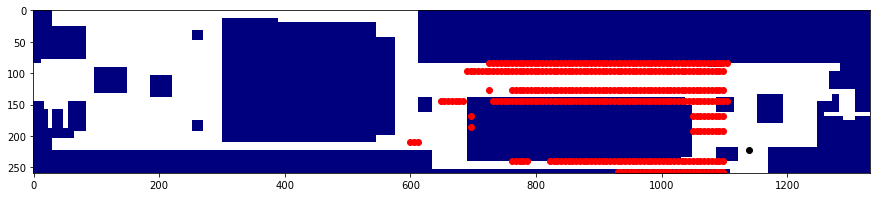

84 258 600 1104
228.0 1140.0


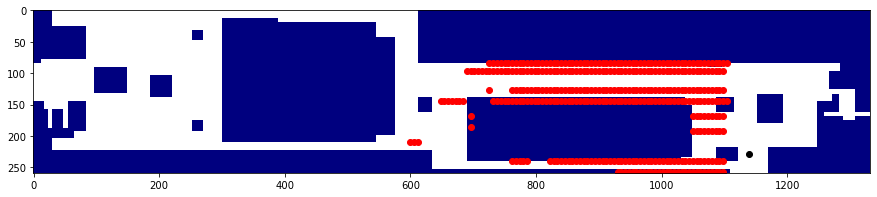

84 258 600 1104
234.0 1140.0


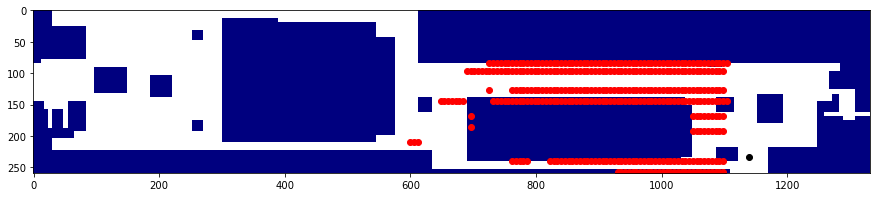

84 258 696 1104
240.0 1140.0


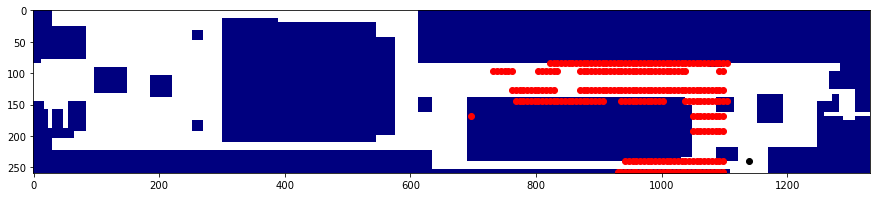

84 258 696 1104
246.0 1140.0


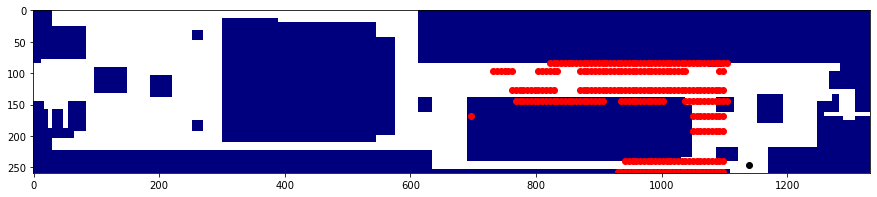

84 258 600 1104
252.0 1110.0


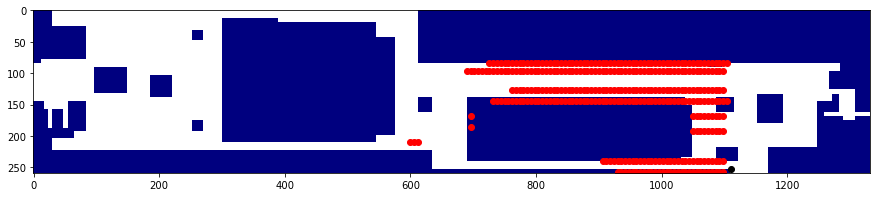

84 258 600 1104
252.0 1116.0


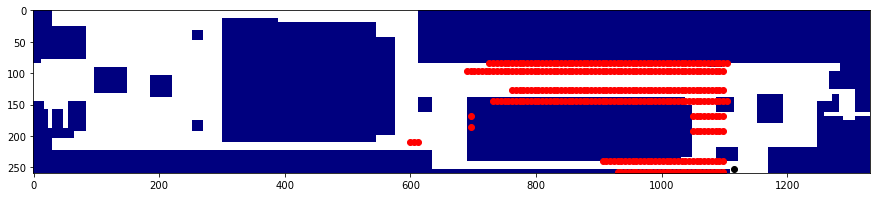

84 258 600 1104
252.0 1122.0


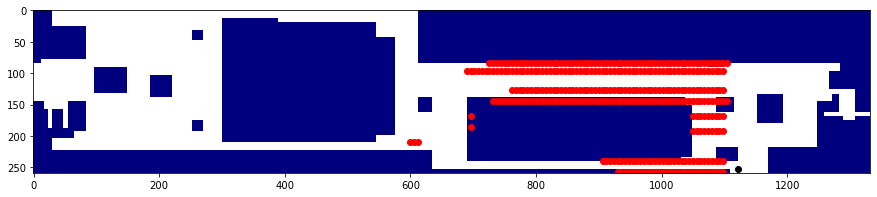

84 258 600 1104
252.0 1128.0


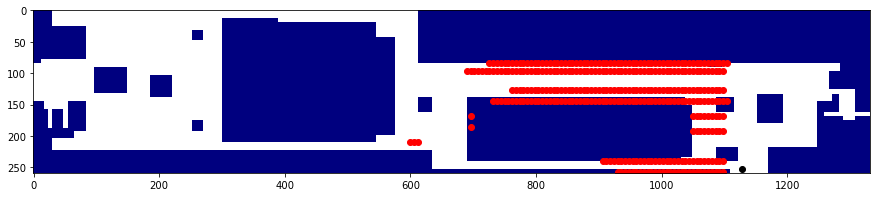

84 258 696 1104
252.0 1134.0


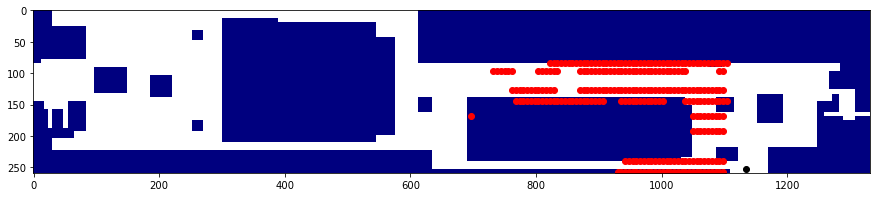

84 258 696 1104
252.0 1140.0


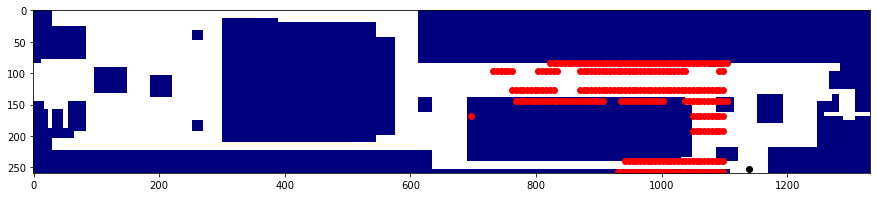

In [65]:
for i in range(len(fail)):
    x_list = fail[i][2][0]
    y_list = fail[i][2][1]
    
    ans_x = fail[i][0]
    ans_y = fail[i][1]
    
    print(min(x_list), max(x_list), min(y_list), max(y_list))

    print(ans_x, ans_y)

    # plt.figure(figsize = (15, 11))
    # plt.imshow(mag_df, cmap='jet', interpolation='none')
    # plt.scatter(org_y_list, org_x_list, c = 'b')
    # plt.scatter(y, x, c = 'r')


    plt.figure(figsize = (15, 11))
    plt.imshow(model.mag_df, cmap='jet', interpolation='none')
    plt.scatter(y_list, x_list, c = 'r')
    plt.scatter(ans_y, ans_x, c = 'black')

    plt.show()